# The purpose of this notebook

In discussion with Michael, I mentioned that we support our use of a linear model of the suppression data by showing that it has better mean and median R^2 than a linear fit to the log-logged data. However, both box plots of fits showed a group of curves (each being one eye of one patient viewing the target under a certain surround/presentation condition etc) that were very badly fit by either model, like near zero and enough to be outliers on a boxplot. So, we thought maybe we'd remove them and see if that changes the results. That's what I'm attempting to do here; The immediately previous notebook, whose graphs are in redo-201901, are the comparison (these are in redo-2901902-exclude_bad_fits)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import string

import numpy as np
np.set_printoptions(precision=3)

import pandas as pd
import scipy.stats as st
import statsmodels.stats.multitest as mt

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils

In [4]:
pd.__version__

'0.24.2'

In [5]:
sns.__version__

'0.9.0'

In [6]:
sns

<module 'seaborn' from '//anaconda/envs/py36/lib/python3.6/site-packages/seaborn/__init__.py'>

In [7]:
gaba_fn = 'gaba_data_2019.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [8]:
sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all' #'motor' # or 'occ_binoc', 'mean_occ_all', 'motor'
gdf = utils.load_gaba(gaba_fn, gaba_col)
sdf.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


In [9]:
gdf.Population = gdf.Population.astype('category')
gdf.Population.cat.categories # 0 AMB 1 CON
gdf.Population = gdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted persons'])

In [10]:
demos = pd.read_csv('demos.csv', lineterminator="\r")
# 1 = amb, 0 = control
subs_to_swap_eyes = demos[demos.swapNDE_EY==1].initials.unique() # subjects whose NDE/DE assignment is wrong in sdf
print(subs_to_swap_eyes)
demos

['ai' 'ct' 'dl' 'ei' 'kw' 'nl']


,numID,initials,scanID,age,sex,labelSex,group,labelGroup,sexGroupNum,ambType,...,hasSS,nde,labelNDE,originNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,AC_081714,36,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.204120,0.116910,0.321030,0.198,0.215
1,3,ai,AI_032814,29,1,female,0,NSP,1,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.223,0.236
2,6,as,AS_071814,39,1,female,1,PWA,3,1,...,0,1,left,iodAcuity,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,BI_050514,52,1,female,1,PWA,3,1,...,1,2,right,iodAcuity,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,CH_072314,33,1,female,1,PWA,3,2,...,0,1,left,iodAcuity,0,-0.084939,1.176091,1.261030,0.184,NaN
5,11,cr,CR_060414,38,2,male,0,NSP,2,0,...,1,2,right,baselineSS,0,NaN,NaN,NaN,0.201,0.204
6,12,cs,CS_072714,46,2,male,1,PWA,4,1,...,0,2,right,iodAcuity,0,-0.096910,0.281030,0.377940,0.220,NaN
7,13,ct,CT_032514,18,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.208,0.208
8,14,dl,DL_082214,67,2,male,0,NSP,2,0,...,1,2,right,baselineSS,1,NaN,NaN,NaN,0.220,0.216
9,16,ei,EI_030214,39,2,male,0,NSP,2,0,...,1,1,left,baselineSS,1,NaN,NaN,NaN,0.200,0.203


### Set variables used for graphing

In [11]:
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\npersons, DE", f"Normally-sighted\npersons, NDE"]
plot_dir = f"plots/redo-202001-{gaba_col}-fixeyes"

## Analyze tasks separately (before subsetting to include common subjects)##

In [12]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [13]:
gdf

,subjName,Population,Presentation,GABA
2,ac,Persons with Amblyopia,mean_occ_all,0.198
6,am,Persons with Amblyopia,mean_occ_all,0.194
10,as,Persons with Amblyopia,mean_occ_all,0.217
14,bi,Persons with Amblyopia,mean_occ_all,0.205
18,ch,Persons with Amblyopia,mean_occ_all,0.184
22,cs,Persons with Amblyopia,mean_occ_all,0.220
26,em,Persons with Amblyopia,mean_occ_all,0.185
30,gd,Persons with Amblyopia,mean_occ_all,0.197
34,jv,Persons with Amblyopia,mean_occ_all,0.201
38,ks,Persons with Amblyopia,mean_occ_all,0.207


#### Remove AM and TT based on discussions with Kelly 12/2019.

In [14]:
gdf_reduced = gdf[(gdf.subjName != 'am') & (gdf.subjName !='tt')]
pop_group_reduced = gdf_reduced.groupby("Population")
pop_group_reduced.describe()

GABA                                             \
                         count      mean       std    min      25%    50%   
Population                                                                  
Persons with Amblyopia    14.0  0.202929  0.012092  0.184  0.19725  0.203   
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.19850  0.203   

                                          
                              75%    max  
Population                                
Persons with Amblyopia    0.21375  0.220  
Normally-sighted persons  0.21100  0.223

In [15]:
#print(*pop_group_reduced['GABA'])
gaba_per_group = [col for col_name, col in pop_group_reduced['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-0.7154537449760943 0.48047050303580596


In [16]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
                         count      mean       std    min     50%    max
Population                                                              
Persons with Amblyopia    16.0  0.199813  0.015276  0.162  0.2005  0.220
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.2030  0.223

In [17]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-1.30189405829905 0.20319932494233123


**Thus we find no significant difference in GABA levels between CON and AMB regardless of whether AM and TT are included. At this point we may as well proceed with gdf_reduced only.**

### GABA violin plot, all subjects

In [18]:
gdf = gdf_reduced.copy()
gaba_df_immutable = gdf_reduced.copy()
gaba_df_immutable.groupby("Population").describe() # Shoud be 14 PWA due to AM, TT exclusion

GABA                                             \
                         count      mean       std    min      25%    50%   
Population                                                                  
Persons with Amblyopia    14.0  0.202929  0.012092  0.184  0.19725  0.203   
Normally-sighted persons  15.0  0.205800  0.009443  0.193  0.19850  0.203   

                                          
                              75%    max  
Population                                
Persons with Amblyopia    0.21375  0.220  
Normally-sighted persons  0.21100  0.223

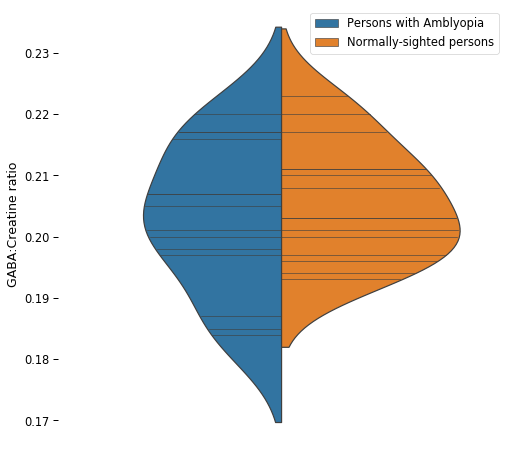

In [19]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n{n_gaba_subjs}_{gaba_col}.pdf") as pdf:
    #with sns.plotting_context(context=None, font_scale=1.3):
    sns.set_context(context="paper", font_scale=1.3)
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gaba_df_immutable,split=True,inner='stick',ax=ax,legend=False)
    ax.legend()
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    sns.despine(left=True, bottom=True, right=True)
    #ax.set_yticklabels([])
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

### Note: the subject with the lowest GABA:Cr ('tt', .162) is not in the psychophysics data

# Select one psychophysical task's data #

In [20]:
task = 'SS'
sdf = sdf[sdf['Task']==task]
df_to_model = sdf.copy() # make a deep copy

In [21]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


In [22]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="Amblyope"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


### Verifying baselines based on KB feedback about fig R2

In [23]:
onecond = df_to_model[(df_to_model['Presentation']=='nMono') & (df_to_model['Orientation']=='Iso')]

In [24]:
cnde_subs = onecond[onecond['Trace']=='Control-Nde'].Subject.unique()

In [25]:
cde_subs = onecond[onecond['Trace']=='Control-De'].Subject.unique()

In [26]:
np.setdiff1d(cnde_subs, cde_subs)

array(['ap', 'bo', 'gw', 'ke', 'nn', 'tj'], dtype=object)

In [27]:
onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace'])['BaselineThresh'].describe()

count      mean  \
Task Orientation Presentation Population Eye Trace                           
SS   Iso         nMono        Amblyope   De  Amblyope-De    53.0  6.201226   
                                         Nde Amblyope-Nde   54.0  7.201574   
                              Control    De  Control-De     54.0  6.306926   
                                         Nde Control-Nde    85.0  5.879106   

                                                                std    min  \
Task Orientation Presentation Population Eye Trace                           
SS   Iso         nMono        Amblyope   De  Amblyope-De   1.216117  4.063   
                                         Nde Amblyope-Nde  2.227975  4.558   
                              Control    De  Control-De    1.449616  4.033   
                                         Nde Control-Nde   1.339842  3.124   

                                                             25%    50%  \
Task Orientation Presentation Population Eye Trace                        
SS   Iso         nMono        Amblyope   De  Amblyope-De   5.949  6.262   
                                         Nde Amblyope-Nde  5.944  6.787   
                              Control    De  Control-De    5.478  6.458   
                                         Nde Control-Nde   5.006  5.741   

                                                             75%     max  
Task Orientation Presentation Population Eye Trace                        
SS   Iso         nMono        Amblyope   De  Amblyope-De   6.826   7.827  
                                         Nde Amblyope-Nde  7.834  13.226  
                              Control    De  Control-De    6.892   9.987  
                                         Nde Control-Nde   6.405   8.794

In [28]:
onecond.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace',"Subject"])['BaselineThresh'].describe()

count  \
Task Orientation Presentation Population Eye Trace        Subject          
SS   Iso         nMono        Amblyope   De  Amblyope-De  ah         5.0   
                                                          am         5.0   
                                                          bi         3.0   
                                                          cl         4.0   
                                                          eg         5.0   
                                                          em         4.0   
                                                          gd         5.0   
                                                          jv         3.0   
                                                          li         5.0   
                                                          mg         3.0   
                                                          mv         4.0   
                                                          rn         3.0   
                                                          sd         4.0   
                                         Nde Amblyope-Nde ah         5.0   
                                                          am         5.0   
                                                          bi         3.0   
                                                          cl         4.0   
                                                          eg         5.0   
                                                          em         4.0   
                                                          gd         5.0   
                                                          jv         4.0   
                                                          li         5.0   
                                                          mg         3.0   
                                                          mv         4.0   
                                                          rn         3.0   
                                                          sd         4.0   
                              Control    De  Control-De   ai         3.0   
                                                          cr         3.0   
                                                          ct         3.0   
                                                          dl         5.0   
...                                                                  ...   
                                                          kw         3.0   
                                                          ls         3.0   
                                                          mk         3.0   
                                                          ms         3.0   
                                                          nl         3.0   
                                                          se         3.0   
                                                          tm         3.0   
                                                          yl         3.0   
                                         Nde Control-Nde  ai         3.0   
                                                          ap         6.0   
                                                          bo         5.0   
                                                          cr         3.0   
                                                          ct         3.0   
                                                          dl         5.0   
                                                          ei         3.0   
                                                          es         5.0   
                                                          gm         5.0   
                                                          gw         5.0   
                                                          jd         3.0   
                                                          ke         5.0   
                                       

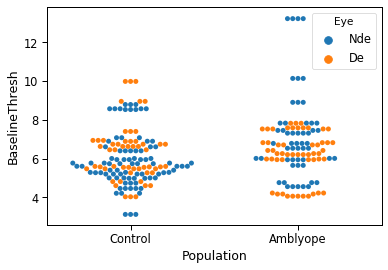

In [29]:
sns.swarmplot(data=onecond, x="Population", y="BaselineThresh", hue="Eye")

### This is where the NDE/DE should be switched based on KB findings (only affects Controls, luckily)

But as the above plot shows, there are many more in Control-Nde than Control-De

In [30]:
def swap_eyevars(df, subs=subs_to_swap_eyes):
    #print(df, df['Subject'], len(df), sep='\n')
    if df['Subject'] in subs: # fix here
        print(df['Subject'], "SWAP!")
        if df['Eye'] == "De":
            df['Eye'] = "Nde"
            df['Trace'] = df['Trace'].replace('-De', '-Nde')
        else:
            df['Eye'] = "De"
            df['Trace'] = df['Trace'].replace('-Nde', '-De')
    return df

def fix_eyes(df):
    disp_cols = ['Subject','Eye','Trace','BaselineThresh']
    rows_to_change = df_to_model[df_to_model.Subject.isin(subs_to_swap_eyes)]
    print(rows_to_change[disp_cols])
    assert(np.all(rows_to_change.Population == 'Control')) # should only affect controls
    assert(np.all(rows_to_change.Trace.isin(['Control-De','Control-Nde']))) # these should be swapped along w/ Eye
    fixed = df.apply(swap_eyevars, axis=1)
    print(fixed[disp_cols])
    return fixed

df_to_model_fixeyes = fix_eyes(df_to_model)

    Subject  Eye        Trace  BaselineThresh
0        ai  Nde  Control-Nde           6.900
1        ai  Nde  Control-Nde           6.900
2        ai  Nde  Control-Nde           6.900
17       ct  Nde  Control-Nde           8.794
18       ct  Nde  Control-Nde           8.794
19       ct  Nde  Control-Nde           8.794
20       dl  Nde  Control-Nde           5.772
21       dl  Nde  Control-Nde           5.772
22       dl  Nde  Control-Nde           5.772
23       dl  Nde  Control-Nde           5.772
24       dl  Nde  Control-Nde           5.772
25       ei  Nde  Control-Nde           4.985
26       ei  Nde  Control-Nde           4.985
27       ei  Nde  Control-Nde           4.985
51       kw  Nde  Control-Nde           5.292
52       kw  Nde  Control-Nde           5.292
53       kw  Nde  Control-Nde           5.292
63       nl  Nde  Control-Nde           5.276
64       nl  Nde  Control-Nde           5.276
65       nl  Nde  Control-Nde           5.276
139      ai   De   Control-De     

In [31]:
df_to_model_fixeyes.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace'])['BaselineThresh'].describe()

count      mean  \
Task Orientation Presentation Population Eye Trace                           
SS   Cross       nDicho       Amblyope   De  Amblyope-De    51.0  6.138412   
                                         Nde Amblyope-Nde   49.0  7.232224   
                              Control    De  Control-De     54.0  6.131833   
                                         Nde Control-Nde    84.0  5.959571   
                 nMono        Amblyope   De  Amblyope-De    53.0  6.137774   
                                         Nde Amblyope-Nde   52.0  7.299288   
                              Control    De  Control-De     54.0  6.131833   
                                         Nde Control-Nde    88.0  5.986636   
     Iso         nDicho       Amblyope   De  Amblyope-De    51.0  6.204353   
                                         Nde Amblyope-Nde   49.0  7.177245   
                              Control    De  Control-De     54.0  6.131833   
                                         Nde Control-Nde    85.0  5.990341   
                 nMono        Amblyope   De  Amblyope-De    53.0  6.201226   
                                         Nde Amblyope-Nde   54.0  7.201574   
                              Control    De  Control-De     54.0  6.131833   
                                         Nde Control-Nde    85.0  5.990341   

                                                                std    min  \
Task Orientation Presentation Population Eye Trace                           
SS   Cross       nDicho       Amblyope   De  Amblyope-De   1.253957  4.063   
                                         Nde Amblyope-Nde  2.095747  4.558   
                              Control    De  Control-De    1.446045  4.033   
                                         Nde Control-Nde   1.344178  3.124   
                 nMono        Amblyope   De  Amblyope-De   1.229919  4.063   
                                         Nde Amblyope-Nde  2.212525  4.558   
                              Control    De  Control-De    1.446045  4.033   
                                         Nde Control-Nde   1.342453  3.124   
     Iso         nDicho       Amblyope   De  Amblyope-De   1.239776  4.063   
                                         Nde Amblyope-Nde  2.124836  4.558   
                              Control    De  Control-De    1.446045  4.033   
                                         Nde Control-Nde   1.365936  3.124   
                 nMono        Amblyope   De  Amblyope-De   1.216117  4.063   
                                         Nde Amblyope-Nde  2.227975  4.558   
                              Control    De  Control-De    1.446045  4.033   
                                         Nde Control-Nde   1.365936  3.124   

                                                               25%    50%  \
Task Orientation Presentation Population Eye Trace                          
SS   Cross       nDicho       Amblyope   De  Amblyope-De   5.94900  6.262   
                                         Nde Amblyope-Nde  5.94400  6.787   
                              Control    De  Control-De    5.27600  5.576   
                                         Nde Control-Nde   5.00600  5.741   
                 nMono        Amblyope   De  Amblyope-De   5.94900  6.262   
                                         Nde Amblyope-Nde  5.94400  6.787   
                              Control    De  Control-De    5.27600  5.576   
                                         Nde Control-Nde   5.15525  5.741   
     Iso         nDicho       Amblyope   De  Amblyope-De   5.94900  6.262   
                                         Nde Amblyope-Nde  5.94400  6.787   
                              Control    De  Control-De    5.27600  5.576   
                                         Nde Control-Nde   5.00600  5.741   
                 nMono        Amblyope   De  Amblyope-De   5.94900  6.262   
                                         Nde Amblyope-Nde  5.94400  6.787   
                 

In [32]:
df_to_model_fixeyes.groupby(['Task','Orientation','Presentation','Population', 'Eye','Trace',"Subject"])['BaselineThresh'].describe()

count  \
Task Orientation Presentation Population Eye Trace        Subject          
SS   Cross       nDicho       Amblyope   De  Amblyope-De  ah         4.0   
                                                          am         5.0   
                                                          bi         3.0   
                                                          cl         4.0   
                                                          eg         5.0   
                                                          em         4.0   
                                                          gd         5.0   
                                                          jv         4.0   
                                                          li         5.0   
                                                          mg         3.0   
                                                          mv         3.0   
                                                          rn         3.0   
                                                          sd         3.0   
                                         Nde Amblyope-Nde ah         4.0   
                                                          am         5.0   
                                                          bi         3.0   
                                                          cl         4.0   
                                                          eg         5.0   
                                                          em         3.0   
                                                          gd         5.0   
                                                          jv         3.0   
                                                          li         5.0   
                                                          mg         3.0   
                                                          mv         3.0   
                                                          rn         3.0   
                                                          sd         3.0   
                              Control    De  Control-De   ai         3.0   
                                                          cr         3.0   
                                                          ct         3.0   
                                                          dl         5.0   
...                                                                  ...   
     Iso         nMono        Control    De  Control-De   kw         3.0   
                                                          ls         3.0   
                                                          mk         3.0   
                                                          ms         3.0   
                                                          nl         3.0   
                                                          se         3.0   
                                                          tm         3.0   
                                                          yl         3.0   
                                         Nde Control-Nde  ai         3.0   
                                                          ap         6.0   
                                                          bo         5.0   
                                                          cr         3.0   
                                                          ct         3.0   
                                                          dl         5.0   
                                                          ei         3.0   
                                                          es         5.0   
                                                          gm         5.0   
                                                          gw         5.0   
                                                          jd         3.0   
                                                          ke         5.0   
                                       

### Toggle which version of the data to use, "fixed" eyes or not

In [33]:
df_to_model = df_to_model_fixeyes

### GABA vs baseline contrast threshold, before excluding bad fits

In [34]:
baseline_gaba_plot_df = df_to_model.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [35]:
simple_bg_df = baseline_gaba_plot_df.groupby(['Task','Orientation','Presentation','Population','Subject','Eye','Trace'])[['GABA','BaselineThresh']].agg(np.mean).reset_index()

In [36]:
simple_bg_df = simple_bg_df.rename(columns={"BaselineThresh":"value"})
simple_bg_df['measure'] = "BaselineThresh"
simple_bg_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,GABA,value,measure
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,NaN,7.590,BaselineThresh
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,NaN,4.558,BaselineThresh
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,NaN,7.532,BaselineThresh
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,NaN,7.834,BaselineThresh
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,0.205,7.827,BaselineThresh


In [37]:
len(simple_bg_df.Subject.unique())

35

In [38]:
simple_bg_df.Trace = simple_bg_df.Trace.astype('category')
simple_bg_df.Trace.cat.reorder_categories(traces4, inplace=True)
simple_bg_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

In [39]:
simple_bg_df.groupby(['Task','Orientation','Presentation','Population', 'Eye', 'Trace', 'measure'])['value'].describe()

count  \
Task Orientation Presentation Population Eye Trace                          measure                 
SS   Cross       nDicho       Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh   13.0   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh   13.0   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh   16.0   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh   22.0   
                 nMono        Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh   13.0   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh   13.0   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh   16.0   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh   22.0   
     Iso         nDicho       Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh   13.0   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh   13.0   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh   16.0   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh   22.0   
                 nMono        Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh   13.0   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh   13.0   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh   16.0   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh   22.0   

                                                                                                mean  \
Task Orientation Presentation Population Eye Trace                          measure                    
SS   Cross       nDicho       Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh  6.136462   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh  7.318385   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh  6.153313   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh  6.008727   
                 nMono        Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh  6.136462   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh  7.318385   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh  6.153313   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh  6.008727   
     Iso         nDicho       Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh  6.136462   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh  7.318385   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh  6.153313   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh  6.008727   
                 nMono        Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh  6.136462   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThresh  7.318385   
                              Control    De  Normally-sighted\npersons, DE  BaselineThresh  6.153313   
                                         Nde Normally-sighted\npersons, NDE BaselineThresh  6.008727   

                                                                                                 std  \
Task Orientation Presentation Population Eye Trace                          measure                    
SS   Cross       nDicho       Amblyope   De  Persons with\nAmblyopia, DE    BaselineThresh  1.280663   
                                         Nde Persons with\nAmblyopia, NDE   BaselineThre

In [40]:
bg_groups = simple_bg_df.groupby(['Task','Orientation','Presentation','measure'])
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_{gaba_col}_baselines_noexc.pdf") as pdf:
    sns.set_context(context="paper", font_scale=1.3)
    for gv, gr in bg_groups:
        print(gv)
        g = s.gaba_vs_psychophys_plot(gv, gr,
                    legend_box=[0.9, 0.60, 0.1, 0.15],
                    col="Population", hue="Trace",
                    palette=colors4,
                    n_boot=5000, legend_img=False, markers=['o','s','o','s'])
        #g.fig.suptitle(f"{gv}", fontsize=10, y=0.999)
        g.set_titles("")
        g.fig.subplots_adjust(left=.08, wspace=.1, right=.82)
        pdf.savefig(g.fig)
        plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'BaselineThresh')


# Modeling

In [41]:
df_to_model.head() # note the first rows, they will tell if fixed - ai/Nde/6.9 -> ai/De/6.9 

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,De,Control,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,De,Control,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,De,Control,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [42]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

groups_with_baseline = df_to_model.groupby(pp_gvars_base)

# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

#### BaselineThresh analysis before we exclude bad fits; since this is observed not modeled its ok

In [43]:
print(pp_gvars_base)
pp_gvars_base_agg = [v for v in pp_gvars if v != 'Subject']

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [44]:
pp_gvars_base_agg

['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace']

In [45]:
for gv, g in df_to_model.groupby(pp_gvars_base_agg):
    print(gv, len(np.unique(g['BaselineThresh'])))

('SS', 'Cross', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nMono', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nMono', 'Control', 'Nde', 'Control-Nde') 22


In [46]:
df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population']).apply(utils.test_baseline_diffs)

Task                  SS
Orientation        Cross
Presentation      nDicho
Population      Amblyope
Name: 816, dtype: object
[ 4.558  4.764  5.654  5.944  6.014  6.536  6.787  7.316  7.458  7.834
  8.907 10.141 13.226] 13 
 [4.063 4.174 4.227 5.949 5.981 6.21  6.262 6.424 6.709 6.826 7.532 7.59
 7.827] 13
Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Task                  SS
Orientation        Cross
Presentation      nDicho
Population      Amblyope
Name: 816, dtype: object
[ 4.558  4.764  5.654  5.944  6.014  6.536  6.787  7.316  7.458  7.834
  8.907 10.141 13.226] 13 
 [4.063 4.174 4.227 5.949 5.981 6.21  6.262 6.424 6.709 6.826 7.532 7.59
 7.827] 13
Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Task                 SS
Orientation       Cross
Presentation     nDicho
Population      Control
Name: 732, dtype: object
[3.124 4.214 4.462 4.738 4.818 5.006 5.205 5.405 5.601 5.608 5.741 5.952
 6.009 6.405 6.458 6.611 6.745 6.943 7.081 8

Task  Orientation  Presentation  Population
SS    Cross        nDicho        Amblyope       (1.5848909585669702, 0.12608067735589273)
                                 Control       (-0.29386802292094555, 0.7705464247762913)
                   nMono         Amblyope       (1.5848909585669702, 0.12608067735589273)
                                 Control       (-0.29386802292094555, 0.7705464247762913)
      Iso          nDicho        Amblyope       (1.5848909585669702, 0.12608067735589273)
                                 Control       (-0.29386802292094555, 0.7705464247762913)
                   nMono         Amblyope       (1.5848909585669702, 0.12608067735589273)
                                 Control       (-0.29386802292094555, 0.7705464247762913)
dtype: object

In [47]:
baseline_df = df_to_model.groupby(pp_gvars_base_agg).apply(utils.describe_baselines).reset_index()

In [48]:
baseline_df

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM
0,SS,Cross,nDicho,Amblyope,De,Amblyope-De,13.0,6.138412,1.230422,0.341258
1,SS,Cross,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.232224,2.271492,0.629998
2,SS,Cross,nDicho,Control,De,Control-De,16.0,6.131833,1.508262,0.377066
3,SS,Cross,nDicho,Control,Nde,Control-Nde,22.0,5.959571,1.419454,0.302629
4,SS,Cross,nMono,Amblyope,De,Amblyope-De,13.0,6.137774,1.230422,0.341258
5,SS,Cross,nMono,Amblyope,Nde,Amblyope-Nde,13.0,7.299288,2.271492,0.629998
6,SS,Cross,nMono,Control,De,Control-De,16.0,6.131833,1.508262,0.377066
7,SS,Cross,nMono,Control,Nde,Control-Nde,22.0,5.986636,1.419454,0.302629
8,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.204353,1.230422,0.341258
9,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.177245,2.271492,0.629998


In [49]:
baseline_df_reduced = baseline_df[(baseline_df.Orientation=='Iso') & (baseline_df.Presentation=='nDicho')]
baseline_df_reduced

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM
8,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.204353,1.230422,0.341258
9,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.177245,2.271492,0.629998
10,SS,Iso,nDicho,Control,De,Control-De,16.0,6.131833,1.508262,0.377066
11,SS,Iso,nDicho,Control,Nde,Control-Nde,22.0,5.990341,1.419454,0.302629


In [50]:
baseline_plot_df = utils.make_baseline_df_to_plot(baseline_df_reduced)

In [51]:
baseline_plot_df.head()

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM,BaselineDiff
8,SS,Iso,nDicho,Amblyope,De,Amblyope-De,13.0,6.204353,1.230422,0.341258,0.972892
9,SS,Iso,nDicho,Amblyope,Nde,Amblyope-Nde,13.0,7.177245,2.271492,0.629998,0.972892
10,SS,Iso,nDicho,Control,De,Control-De,16.0,6.131833,1.508262,0.377066,-0.141492
11,SS,Iso,nDicho,Control,Nde,Control-Nde,22.0,5.990341,1.419454,0.302629,-0.141492


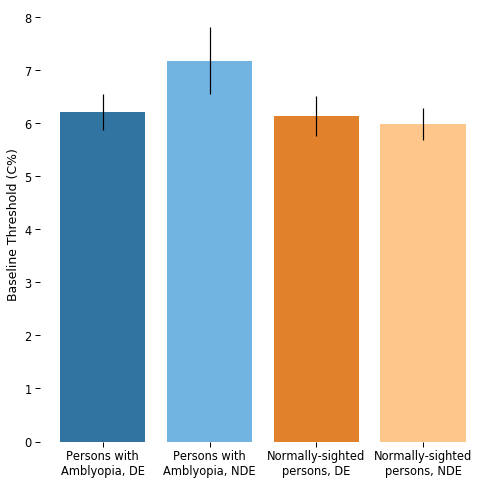

In [52]:
with s.PdfPages(f"{plot_dir}/{task}_baseline_diffs.pdf") as pdf:
    sns.set_context(context="paper", font_scale=1.3)
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    x_pos = np.arange(len(baseline_plot_df['Trace']))
    plt.bar(x_pos, baseline_plot_df['mean'], data=baseline_plot_df, yerr='SEM', color=colors4)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(traces_graph4)
    ax.set_ylabel('Baseline Threshold (C%)')
    sns.despine(left=True, bottom=True, right=True, top=True)
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')
    

### Linear model using statsmodels

In [53]:
lin_results = groups_with_baseline.apply(utils.linear_fit_params, 'RelMaskContrast', 'ThreshElev').reset_index()

In [54]:
lin_results.head(n=16)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.473458,0.008358,0.150669
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.035803,0.079161,0.878492
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,0.859762,0.014954,0.546837
5,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,0.712554,0.244377,0.992124
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
7,SS,Cross,nDicho,Amblyope,cl,Nde,Amblyope-Nde,7.458,1.044474,0.761080,0.943153
8,SS,Cross,nDicho,Amblyope,eg,De,Amblyope-De,6.826,0.986000,0.039389,0.722331
9,SS,Cross,nDicho,Amblyope,eg,Nde,Amblyope-Nde,6.787,1.004564,0.026249,0.659700


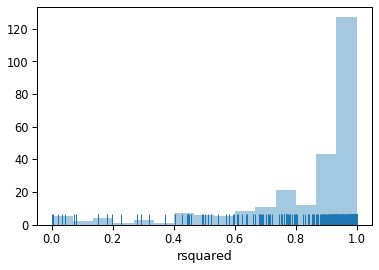

In [55]:
sns.distplot(lin_results.rsquared, kde=False, rug=True)

In [56]:
np.count_nonzero(lin_results.rsquared>.999999)

0

In [57]:
lin_results.rsquared.mean()

0.8354424459253054

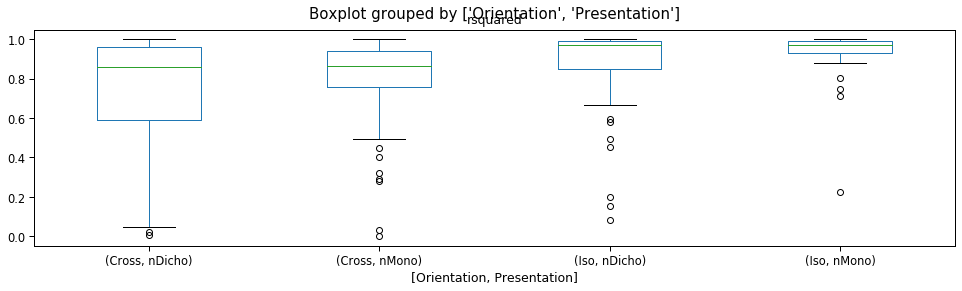

In [58]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Presentation'], grid=False, figsize=(16, 4))

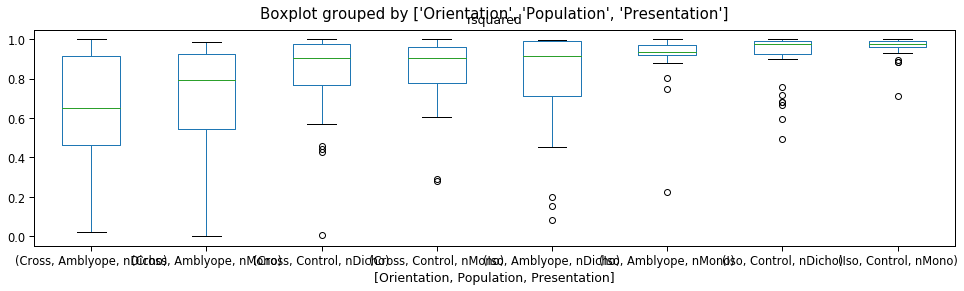

In [59]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

### Fit the log-logged data to see if that's better

In [60]:
log_results = groups_with_baseline.apply(utils.linear_fit_params, 'logRelMaskContrast', 'logThreshElev').reset_index()

log_results.rsquared.mean()

0.7417445472530506

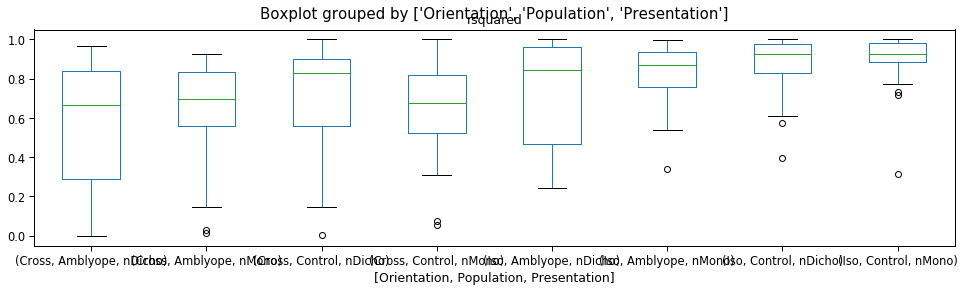

In [61]:
log_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

## Conclusion: linear fits are overall better.

## Identify subjects with negative slope (for Jian)

In [62]:
neg_slopes = lin_results[lin_results['slope']<0]
neg_slopes

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
12,SS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,6.210,1.023065,-0.006021,0.045044
14,SS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,4.227,1.689517,-0.020405,0.181212
20,SS,Cross,nDicho,Amblyope,mv,De,Amblyope-De,5.981,1.260735,-0.020939,0.503098
22,SS,Cross,nDicho,Amblyope,rn,De,Amblyope-De,6.424,0.757355,-0.017022,0.021744
24,SS,Cross,nDicho,Amblyope,sd,De,Amblyope-De,6.262,0.706531,-0.017487,0.073372
53,SS,Cross,nDicho,Control,ms,Nde,Control-Nde,4.214,0.942228,-0.004734,0.622978
78,SS,Cross,nMono,Amblyope,jv,De,Amblyope-De,4.227,1.861288,-0.038142,0.319723
86,SS,Cross,nMono,Amblyope,rn,De,Amblyope-De,6.424,0.933673,-0.033097,0.494020
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.006648,-0.013177,0.152790


In [63]:
neg_slopes.Subject.unique()

array(['cl', 'gd', 'jv', 'mv', 'rn', 'sd', 'ms', 'bi', 'ct'], dtype=object)

## Exclude bad fits (new 2019-02-25)

In [64]:
len(lin_results)

256

In [65]:
lin_results_exc = lin_results.groupby(['Task', 'Population']).apply(utils.remove_outliers_halfvar).reset_index(drop=True)

In [66]:
lin_results_exc.rsquared.min()

0.5030976163556411

In [67]:
lin_results_exc.Subject.value_counts().sum()

231

In [68]:
231/256

0.90234375

In [69]:
pp_subs_exc = lin_results_exc.Subject.unique()
print(f'There are {len(pp_subs_exc)} unique subjects who have at least one condition of data.')

There are 35 unique subjects who have at least one condition of data.


## Actually use the linear model to predict thresholds

In [70]:
lin_preds = groups_with_baseline.apply(utils.linear_fit_predictions, 'RelMaskContrast', 'ThreshElev').reset_index()

In [71]:
lin_preds.columns

Index(['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye',
       'Trace', 'BaselineThresh', 'RelMaskContrast', 'ThreshPred'],
      dtype='object')

In [72]:
lin_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.318,1.411635


In [73]:
plot_df = pd.merge(df_to_model, lin_preds, on=pp_gvars_base + ['RelMaskContrast'])

plot_df.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,ThreshPred
0,ai,SS,nMono,Iso,De,Control,10.0,0.615,0.009,1.449,Control-De,6.900,1.552,2,-0.211125,0.161068,0.475863
1,ai,SS,nMono,Iso,De,Control,30.0,0.671,0.010,4.348,Control-De,6.900,3.944,4,-0.173277,0.638290,0.897104
2,ai,SS,nMono,Iso,De,Control,62.0,1.658,0.007,8.986,Control-De,6.900,11.345,6,0.219585,0.953566,1.571032
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277,0.656604
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527,0.977298


### Plot observed values and model fits

In [74]:
#s.group_facet_plots(plot_df, s.subject_fit_plot,
#                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOP.pdf",
#                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
#                    row='Population',col='Eye',# facet rows and columns
#                    x="RelMaskContrast", y="ThreshElev", # x, y
#                    hue="Subject",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

In [75]:
#s.group_facet_plots(plot_df, s.population_fit_plot,
#                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TO.pdf",
#                    ['Task','Orientation'], #each combo of this gets its own page
#                    row='Presentation',col='Eye',# facet rows and columns
#                    x="RelMaskContrast", y="ThreshElev", # x, y
#                    hue="Population",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

## Now exclude the predictions for the bad fits

In [76]:
lin_results.Orientation.value_counts()

Iso      128
Cross    128
Name: Orientation, dtype: int64

In [77]:
lin_results_exc.Orientation.value_counts()

Iso      122
Cross    109
Name: Orientation, dtype: int64

In [78]:
lin_results_exc.Population.value_counts()

Control     145
Amblyope     86
Name: Population, dtype: int64

In [79]:
lin_results.Population.value_counts()

Control     152
Amblyope    104
Name: Population, dtype: int64

In [80]:
comb_rsq_preds = pd.merge(lin_results_exc, lin_preds, on=pp_gvars_base)

In [81]:
comb_rsq_preds.rsquared.min()

0.5030976163556411

In [82]:
comb_rsq_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


In [83]:
comb_rsq_preds_noexc = pd.merge(lin_results, lin_preds, on=pp_gvars_base)

In [84]:
comb_rsq_preds_noexc.rsquared.min()

0.002508814671685511

In [85]:
comb_rsq_preds_noexc.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


### Pick an xvalue (RelMaskContrast) to evaluate models at

 * 2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
   * Just looking at it via describe(), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)
 * 2018-10-08: My previous approach was too subjective. Instead, evaluate model at various percentiles...
   * do this separately for Task, Orientation, Presentation (so pick 8 total numbers)
   * At this point it's easier to just use the statsmodels.ols functions maybe? The way it's currently done is a legacy that allows different models to be swapped in... which I hope to god is not going to be the direction we go in again.
   * nvm, used the lmfit solution since it returned a nicely formatted pfit df and is tested to work
   * Here I want to take the slope and y-int and calculate the model prediction at the specified percentiles above (0-1, increments of 0.2). So, first calculate the RelMC at each of those percentiles, then apply it like below.


In [86]:
percentile_bins = np.linspace(0, 1, num=11)

In [87]:
percentile_bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

#### Get the interpolated RelMaskContrasts for each regression line, i.e. the range of x-values

In [88]:
relmc_pcts_df = comb_rsq_preds.groupby(pp_gvars_base)['RelMaskContrast'].describe(percentiles=percentile_bins)

In [89]:
# fix stupid column naming from describe()
relmc_pcts_df.columns = [f"{int(float(col[:-1])):03d}" if col[-1]=="%" else col for col in relmc_pcts_df.columns]

In [90]:
relmc_pcts_df.columns

Index(['count', 'mean', 'std', 'min', '000', '010', '020', '030', '040', '050',
       '060', '070', '080', '090', '100', 'max'],
      dtype='object')

In [91]:
relmc_pcts_df = relmc_pcts_df.filter(regex='0|1')
relmc_pcts_df.head()

000  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh          
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.194   
                                                 Nde Amblyope-Nde 4.558           1.318   
                                         am      Nde Amblyope-Nde 7.834           1.328   
                                         bi      De  Amblyope-De  7.827           0.986   
                                                 Nde Amblyope-Nde 10.141          1.278   

                                                                                     010  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.7205   
                                                 Nde Amblyope-Nde 4.558           1.6342   
                                         am      Nde Amblyope-Nde 7.834           1.7528   
                                         bi      De  Amblyope-De  7.827           1.3804   
                                                 Nde Amblyope-Nde 10.141          1.7890   

                                                                                     020  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.2470   
                                                 Nde Amblyope-Nde 4.558           1.9504   
                                         am      Nde Amblyope-Nde 7.834           2.1776   
                                         bi      De  Amblyope-De  7.827           1.7748   
                                                 Nde Amblyope-Nde 10.141          2.3000   

                                                                                     030  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.7735   
                                                 Nde Amblyope-Nde 4.558           2.2666   
                                         am      Nde Amblyope-Nde 7.834           2.7618   
                                         bi      De  Amblyope-De  7.827           2.1692   
                                                 Nde Amblyope-Nde 10.141          2.8110   

                                                                                     040  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           4.5632   
                                                 Nde Amblyope-Nde 4.558           2.7408   
                                         am      Nde Amblyope-Nde 7.834           3.5054   
                                         bi      De  Amblyope-De  7.827           2.5636   
                                                 Nde Amblyope-Nde 10.141          3.3220   

                                                                                     050  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           5.4845   
                                                 Nde Amblyope-Nde 4.558           3.2940   
                                         am      Nde Amblyope-Nde 7.834           4.2490   
                                         bi      De  Amblyope-De  7.827           2.9580   
                                                 Nde Amblyope-Nde 10.141          3.8330   

                                                                                     060  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyop

In [92]:
relmc_pcts_df.columns

Index(['000', '010', '020', '030', '040', '050', '060', '070', '080', '090',
       '100'],
      dtype='object')

In [93]:
relmc_pcts_df_melted = relmc_pcts_df.reset_index().melt(id_vars=pp_gvars_base, var_name='percentile', value_name='RelMaskContrast_pct')

In [94]:
relmc_pcts_df_melted.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,000,2.194
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,000,1.318
2,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,000,1.328
3,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,000,0.986
4,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,000,1.278


In [95]:
predict_pcts_df = pd.merge(lin_results_exc, relmc_pcts_df_melted, on=pp_gvars_base)

In [96]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,000,2.1940
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,010,2.7205
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,020,3.2470
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,030,3.7735
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,040,4.5632


In [97]:
predict_pcts_df['percentile'] = predict_pcts_df['percentile'].astype(int)
predict_pcts_df['RelMaskContrast_pct'] = predict_pcts_df['RelMaskContrast_pct'].astype(float)
predict_pcts_df['relmc_bin'] = (np.around(predict_pcts_df['RelMaskContrast_pct'])).astype(int)
predict_pcts_df['ThreshElev_pct'] = (predict_pcts_df['y_int'] + (predict_pcts_df['RelMaskContrast_pct']*predict_pcts_df['slope'])).astype('float')

In [98]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,0,2.1940,2,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,10,2.7205,3,0.751589
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,20,3.2470,3,0.760684
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,30,3.7735,4,0.769779
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,40,4.5632,5,0.783421


In [99]:
predict_pcts_df.rsquared.min()

0.5030976163556411

In [100]:
gvars_test = ['Task','Orientation','Presentation','Population']
# equal_var=False makes it Welch's t-test, which does not assume the groups have equal variance
selected_bin_df = utils.find_pct_to_predict(predict_pcts_df, gvars_test,
                    'relmc_bin', 'ThreshElev_pct', test_func=st.ttest_ind, equal_var=False)

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p-value: 0.0001217267
10 DE obs, 17 NDE obs
p-value: 0.0026591129
8 DE obs, 14 NDE obs
p-value: 0.0073737492
8 DE obs, 12 NDE obs
p-value: 0.0344970562
4 DE obs, 13 NDE obs
p-value: 0.0082892146
2 DE obs, 8 NDE obs
p-value: 0.0336034718
3 DE obs, 4 NDE obs
p-value: 0.3643803918
3 DE obs, 5 NDE obs
p-value: 0.0423860511
1 DE obs, 4 NDE obs
p-value: nan
1 DE obs, 4 NDE obs
p-value: nan
2 DE obs, 3 NDE obs
p-value: 0.3205767408
A group with no obs, skipping
A group with no obs, skipping
1 DE obs, 2 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p

//anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


1 DE obs, 4 NDE obs
p-value: nan
2 DE obs, 3 NDE obs
p-value: 0.3205767408
A group with no obs, skipping
A group with no obs, skipping
1 DE obs, 2 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 24 bins in this condition.
7 DE obs, 14 NDE obs
p-value: 0.5173489421
7 DE obs, 14 NDE obs
p-value: 0.5173489421
22 DE obs, 31 NDE obs
p-value: 0.2087782894
21 DE obs, 34 NDE obs
p-value: 0.4025978400
17 DE obs, 22 NDE obs
p-value: 0.5009762075
16 DE obs, 19 NDE obs
p-value: 0.9672675535
10 DE obs, 17 NDE obs
p-value: 0.4709410102
9 DE obs, 13 NDE obs
p-value: 0.7726435799
9 DE obs, 12 NDE obs
p-value: 0.6928377773
7 DE obs, 7 NDE obs
p-value: 0.6129804962
6 DE obs, 10 NDE obs
p-value: 0.3569340741
3 DE obs, 8 NDE obs
p-value: 0.1567434426
5 DE obs, 5 NDE obs
p-value: 0.4204986492
4 DE obs, 5 NDE obs
p-value: 0.0351302295
3 DE obs,

In [101]:
g_TOP = selected_bin_df.groupby(['Task', 'Orientation', 'Presentation'])
def set_relmctopred_to_amb_val(g):
    ambs = g[g['Population']=='Amblyope']
    assert(np.all(ambs['RelMCToPred']==ambs['RelMCToPred'].iat[0]))
    assert(np.all(ambs['BinNumberToPred']==ambs['BinNumberToPred'].iat[0]))
    g['RelMCToPred'] = ambs['RelMCToPred'].iat[0]
    g['BinNumberToPred'] = ambs['BinNumberToPred'].iat[0]
    return g
selected_bin_df = g_TOP.apply(set_relmctopred_to_amb_val).reset_index()

In [102]:
selected_bin_df.groupby(gvars_test)['RelMCToPred','ThreshElev_pct'].describe()

RelMCToPred                           \
                                               count mean  std  min  25%  50%   
Task Orientation Presentation Population                                        
SS   Cross       nDicho       Amblyope         209.0  2.0  0.0  2.0  2.0  2.0   
                              Control          374.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         220.0  2.0  0.0  2.0  2.0  2.0   
                              Control          396.0  2.0  0.0  2.0  2.0  2.0   
     Iso         nDicho       Amblyope         242.0  2.0  0.0  2.0  2.0  2.0   
                              Control          407.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         275.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   

                                                   ThreshElev_pct            \
                                          75%  max          count      mean   
Task Orientation Presentation Population                                      
SS   Cross       nDicho       Amblyope    2.0  2.0          209.0  1.405147   
                              Control     2.0  2.0          374.0  1.270859   
                 nMono        Amblyope    2.0  2.0          220.0  1.016782   
                              Control     2.0  2.0          396.0  0.967216   
     Iso         nDicho       Amblyope    2.0  2.0          242.0  1.683927   
                              Control     2.0  2.0          407.0  1.974481   
                 nMono        Amblyope    2.0  2.0          275.0  1.437772   
                              Control     2.0  2.0          418.0  1.579746   

                                                                        \
                                               std       min       25%   
Task Orientation Presentation Population                                 
SS   Cross       nDicho       Amblyope    0.625566  0.676956  1.012935   
                              Control     0.445897  0.661363  0.939387   
                 nMono        Amblyope    0.314906  0.344715  0.846435   
                              Control     0.262268  0.430126  0.795938   
     Iso         nDicho       Amblyope    1.136489  0.260012  1.023047   
                              Control     0.890109  0.474386  1.343264   
                 nMono        Amblyope    0.824721  0.366306  0.861253   
                              Control     0.938111  0.432981  0.930592   

                                                                        
                                               50%       75%       max  
Task Orientation Presentation Population                                
SS   Cross       nDicho       Amblyope    1.226023  1.565376  4.674826  
                              Control     1.184204  1.470286  3.959224  
                 nMono        Amblyope    0.999258  1.168597  2.219274  
                              Control     0.930215  1.111265  2.078230  
     Iso         nDicho       Amblyope    1.322546  2.025497  6.242498  
                              Control     1.806443  2.409358  5.881773  
                 nMono        Amblyope    1.157459  1.806846  4.903989  
                              Control     1.300831  1.972276  6.689321

In [103]:
selected_bin_df['ThreshPredCritical'] = selected_bin_df['y_int'] + selected_bin_df['slope'] * selected_bin_df['RelMCToPred']
selected_bin_df['ThreshPredCriticalUnnorm'] = selected_bin_df['ThreshPredCritical'] * selected_bin_df['BaselineThresh']

In [104]:
selected_bin_df

,index,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct,BinNumberToPred,RelMCToPred,ThreshPredCritical,ThreshPredCriticalUnnorm
0,0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,0,2.1940,2,0.742493,2,2,0.739142,5.610087
1,1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,10,2.7205,3,0.751589,2,2,0.739142,5.610087
2,2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,20,3.2470,3,0.760684,2,2,0.739142,5.610087
3,3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,30,3.7735,4,0.769779,2,2,0.739142,5.610087
4,4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,40,4.5632,5,0.783421,2,2,0.739142,5.610087
5,5,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,50,5.4845,5,0.799337,2,2,0.739142,5.610087
6,6,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,60,6.4058,6,0.815252,2,2,0.739142,5.610087
7,7,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,70,7.5466,8,0.834960,2,2,0.739142,5.610087
8,8,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,80,9.1264,9,0.862251,2,2,0.739142,5.610087
9,9,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,90,10.7062,11,0.889542,2,2,0.739142,5.610087


### Melt the result of the modeling into long format for plotting

In [105]:
pfit_all_ppsub = pd.melt(selected_bin_df, id_vars=[*pp_gvars, 'rsquared'],
                    value_vars=['BaselineThresh', 'y_int', 'slope', 'ThreshPredCritical', 'ThreshPredCriticalUnnorm'],
                    var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,0.639823,BaselineThresh,7.59
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,0.639823,BaselineThresh,7.59
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,0.639823,BaselineThresh,7.59
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,0.639823,BaselineThresh,7.59
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,0.639823,BaselineThresh,7.59


In [106]:
pp_stats = pfit_all_ppsub[(pfit_all_ppsub.measure=="ThreshPredCritical") | 
                          (pfit_all_ppsub.measure=="slope")].drop_duplicates()

In [107]:
pp_slopes = pfit_all_ppsub[pfit_all_ppsub.measure=="slope"].drop_duplicates()

In [108]:
pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace','measure'])['value'].describe(percentiles=[.5])

count  \
Task Orientation Presentation Population Eye Trace        measure                     
SS   Cross       nDicho       Amblyope   De  Amblyope-De  ThreshPredCritical    6.0   
                                                          slope                 6.0   
                                         Nde Amblyope-Nde ThreshPredCritical   13.0   
                                                          slope                13.0   
                              Control    De  Control-De   ThreshPredCritical   14.0   
                                                          slope                14.0   
                                         Nde Control-Nde  ThreshPredCritical   20.0   
                                                          slope                20.0   
                 nMono        Amblyope   De  Amblyope-De  ThreshPredCritical   11.0   
                                                          slope                11.0   
                                         Nde Amblyope-Nde ThreshPredCritical    9.0   
                                                          slope                 9.0   
                              Control    De  Control-De   ThreshPredCritical   14.0   
                                                          slope                14.0   
                                         Nde Control-Nde  ThreshPredCritical   22.0   
                                                          slope                22.0   
     Iso         nDicho       Amblyope   De  Amblyope-De  ThreshPredCritical   10.0   
                                                          slope                10.0   
                                         Nde Amblyope-Nde ThreshPredCritical   12.0   
                                                          slope                12.0   
                              Control    De  Control-De   ThreshPredCritical   15.0   
                                                          slope                15.0   
                                         Nde Control-Nde  ThreshPredCritical   22.0   
                                                          slope                22.0   
                 nMono        Amblyope   De  Amblyope-De  ThreshPredCritical   13.0   
                                                          slope                13.0   
                                         Nde Amblyope-Nde ThreshPredCritical   12.0   
                                                          slope                12.0   
                              Control    De  Control-De   ThreshPredCritical   16.0   
                                                          slope                16.0   
                                         Nde Control-Nde  ThreshPredCritical   22.0   
                                                          slope                22.0   

                                                                                  mean  \
Task Orientation Presentation Population Eye Trace        measure                        
SS   Cross       nDicho       Amblyope   De  Amblyope-De  ThreshPredCritical  0.982403   
                                                          slope               0.010162   
                                         Nde Amblyope-Nde ThreshPredCritical  1.261471   
                                                          slope               0.239615   
                              Control    De  Control-De   ThreshPredCritical  0.905532   
                                                          slope               0.084865   
                                         Nde Control-Nde  ThreshPredCritical  0.997936   
                                                          slope               0.070346   
                 nMono        Amblyope   De  Amblyope-De  ThreshPredCritical  0.762551   
                                                          slope               0.048930   
                                       

In [109]:
def test_suppression_diffs(g):
    ndes = np.unique(g[g.Eye=='Nde']['value'])
    des = np.unique(g[g.Eye=='De']['value'])
    #g.hist()
    print(len(ndes), ' ', len(des))
    print(st.ttest_ind(ndes, des))
    return st.ttest_ind(ndes, des)

gs = pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'measure'])
for gv, g in gs:
    print(gv)
    test_suppression_diffs(g)

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
13   6
Ttest_indResult(statistic=1.0825104777261156, pvalue=0.2941420574488816)
('SS', 'Cross', 'nDicho', 'Amblyope', 'slope')
13   6
Ttest_indResult(statistic=1.9064791428259615, pvalue=0.07363610125789011)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
20   14
Ttest_indResult(statistic=1.2480432813668088, pvalue=0.2210704712855009)
('SS', 'Cross', 'nDicho', 'Control', 'slope')
20   14
Ttest_indResult(statistic=-0.8014276354259712, pvalue=0.4287952487096549)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
9   11
Ttest_indResult(statistic=2.4749898780674733, pvalue=0.02349657192646339)
('SS', 'Cross', 'nMono', 'Amblyope', 'slope')
9   11
Ttest_indResult(statistic=1.7526701925678212, pvalue=0.09667435764225167)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
22   14
Ttest_indResult(statistic=0.017806935418218775, pvalue=0.9858969600137633)
('SS', 'Cross', 'nMono', 'Control', 'slope')
22   14
Tte

## Subset to include only (GABA and psychophyics) subjects

In [110]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [111]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw'
 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [112]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='Persons with Amblyopia'])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are Amblyopes.')
n_this_task = len(gdf)

Of the 22 subjects with GABA and SS data, 8 are Amblyopes.


In [113]:
stats_thistask = lin_results_exc[lin_results_exc.Subject.isin(gaba_and_pp_subjs_thistask)].groupby(['Subject'])['rsquared'].describe()

In [114]:
stats_thistask

,count,mean,std,min,25%,50%,75%,max
Subject,,,,,,,,
ai,8.0,0.935161,0.117607,0.659733,0.943784,0.986299,0.999719,0.999922
am,6.0,0.910557,0.067258,0.799772,0.887612,0.915914,0.949502,0.992865
bi,7.0,0.916000,0.164366,0.546837,0.952287,0.976332,0.992383,0.999488
cr,8.0,0.945987,0.058601,0.840411,0.904833,0.963965,0.997742,0.999292
ct,7.0,0.937913,0.077187,0.779726,0.926199,0.964989,0.985442,0.997392
dl,6.0,0.893841,0.092011,0.770530,0.821866,0.911476,0.969726,0.988424
ei,7.0,0.922415,0.140298,0.607023,0.954326,0.973990,0.983801,0.999641
em,7.0,0.885701,0.098248,0.745585,0.809151,0.921243,0.957915,0.998944
es,7.0,0.779242,0.124372,0.596832,0.697413,0.766640,0.881903,0.932588


In [115]:
n_gaba_and_pp_subjs_thistask * 8 - stats_thistask['count'].sum()

25.0

## Combine Psychophysics and GABA below

In [116]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb), len(comb_gabappsub))


1155 765


In [117]:
comb_gabappsub.Subject.unique()

array(['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd', 'ai', 'cr', 'ct',
       'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk', 'ms', 'nl', 'yl'],
      dtype=object)

### Add copies of rows to simulate weighting by rsquared

 * (bypassed by modifying seaborn's bootstrap, 2019-08-22)
 * (weighting dropped 2019-08-26 after MAS meeting)

In [118]:
#rep = np.ones(len(comb_gabappsub))
#times = np.around(comb_gabappsub['rsquared']*10)
#.iloc[np.arange(len(comb_gabappsub))]
#print(rep, times, rep*times)
#comb_gabappsub_weighted = comb_gabappsub.iloc[np.arange(len(comb_gabappsub)).repeat(times)]

### Do Spearman's R

In [119]:
spearman_df = comb_gabappsub[(comb_gabappsub.measure == 'BaselineThresh') | 
                             (comb_gabappsub.measure == 'ThreshPredCritical')]

In [120]:
spearman_df.Subject.unique()

array(['bi', 'em', 'gd', 'jv', 'li', 'mg', 'rn', 'sd', 'ai', 'cr', 'ct',
       'dl', 'ei', 'es', 'gm', 'jd', 'kw', 'ls', 'mk', 'ms', 'nl', 'yl'],
      dtype=object)

In [121]:
spearman_df.Trace = spearman_df.Trace.astype('category')
foo_temp = spearman_df.Trace.copy()
spearman_df.Trace.cat.reorder_categories(traces4, inplace=True)
assert(foo_temp.equals(spearman_df.Trace))
spearman_df.Trace.cat.rename_categories(traces_graph4, inplace=True)

//anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [122]:
plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure','Eye','Trace'])
for gv, gr in plot_groups:
    #if 'nDicho' in gv:
    print(gv)
    print(stats.spearmanr(gr.GABA, gr.value))

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'De', 'Persons with\nAmblyopia, DE')
SpearmanrResult(correlation=-0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'Nde', 'Persons with\nAmblyopia, NDE')
SpearmanrResult(correlation=-0.2142857142857143, pvalue=0.6103444156452669)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'De', 'Persons with\nAmblyopia, DE')
SpearmanrResult(correlation=0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'Nde', 'Persons with\nAmblyopia, NDE')
SpearmanrResult(correlation=-0.38095238095238104, pvalue=0.35181255311756476)
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh', 'De', 'Normally-sighted\npersons, DE')
SpearmanrResult(correlation=0.18213688176797005, pvalue=0.5710157812668486)
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh', 'Nde', 'Normally-sighted\npersons, NDE')
SpearmanrResult(correlation=0.14685314685314685, pvalue=0.6487957097846664)

In [123]:
#graphs!
colors_a = ["#3274a1","#72b4e1"]
colors_c = ["#e1812c", "#ffc68c"]
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}.pdf") as pdf:
    plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure'])
    plot_groups_eacheye = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure','Eye'])
    for gv, gr in plot_groups:
        #if gv[2] == 'nDicho':
        print(gv, np.all(np.isnan(gr['value'])), len(gr['value']))
        pal = [colors_a if 'Amblyope' in gv else colors_c]
        g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal[0], aspect=1.2)
        pdf.savefig(g2.fig)

plt.close('all')

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh') False 10
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 10
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh') False 24
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical') False 24
('SS', 'Cross', 'nMono', 'Amblyope', 'BaselineThresh') False 11
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical') False 11
('SS', 'Cross', 'nMono', 'Control', 'BaselineThresh') False 26
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical') False 26
('SS', 'Iso', 'nDicho', 'Amblyope', 'BaselineThresh') False 12
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 12
('SS', 'Iso', 'nDicho', 'Control', 'BaselineThresh') False 27
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical') False 27
('SS', 'Iso', 'nMono', 'Amblyope', 'BaselineThresh') False 15
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical') False 15
('SS', 'Iso', 'nMono', 'Control', 'BaselineThresh') False 28
('SS', 'Iso', 'nMono', 'C

In [124]:
# with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_ind.pdf") as pdf:
#     for gv, gr in plot_groups:
#         print(gv)
#         g = s.gaba_vs_psychophys_plot(gv, gr, hue="Eye",
#                     palette=dict(De="g", Nde="m"),
#                     n_boot=1000, height=8, aspect=1, legend_out=True, truncate=True)
#         g.fig.suptitle(f"{gv} unweighted", fontsize=10, y=0.999)
#         pdf.savefig(g.fig)
#         plt.close('all')

In [125]:
facet_groups = spearman_df.groupby(['Task','Orientation','Presentation','measure'])
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_facet.pdf") as pdf:
    for gv, gr in facet_groups:
        print(gv)
        g = s.gaba_vs_psychophys_plot(gv, gr, 
                    legend_box=[0.9, 0.60, 0.1, 0.15],
                    legend_img = False,
                    col="Population", hue="Trace",
                    palette=colors4,
                    n_boot=1000,
                    markers=['o','s','o','s'])#, legend=False)
        #g.fig.subplots_adjust(wspace=.1)
        pdf.savefig(g.fig)
        plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'BaselineThresh')
('SS', 'Cross', 'nMono', 'ThreshPredCritical')
('SS', 'Cross', 'nMono', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'BaselineThresh')
('SS', 'Iso', 'nMono', 'ThreshPredCritical')
('SS', 'Iso', 'nMono', 'ThreshPredCritical')


In [126]:
facet_groups2 = spearman_df.groupby(['Task','Orientation','measure'])
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_facet_joint.pdf") as pdf:
    for gv, gr in facet_groups2:
        print(gv)
        g = s.gaba_vs_psychophys_plot(gv, gr, 
                    legend_box=[0.9, 0.60, 0.1, 0.15],
                    legend_img = False,
                    row="Presentation", col="Population", hue="Trace",
                    palette=colors4,
                    n_boot=5000,
                    markers=['o','s','o','s'])#, legend=False)
        g.set_titles("")
        g.fig.subplots_adjust(left=.08, right=.82, wspace=0.1)
        pdf.savefig(g.fig)
        plt.close('all')

('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'ThreshPredCritical')
('SS', 'Iso', 'ThreshPredCritical')


In [127]:
rdiffs_nores = facet_groups.apply(utils.compare_rs, n_boot=100, resample=False).reset_index()\
            .rename(columns={"level_4":"iteration"})

('SS', 'Cross', 'nDicho', 'BaselineThresh')
                correlation
Population Eye             
Amblyope   De     -1.000000
           Nde    -0.214286
Control    De      0.182137
           Nde     0.146853
Real (observed) r_s differences:
A	C	P
0.786	-0.0353	0.821
Percentiles for permuted r_s differences:
A [-1.667 -1.667 -1.667 -1.62  -1.573 -1.571 -1.571 -1.143 -0.333  0.988
  1.548  1.717  1.857]
C [-0.801 -0.791 -0.781 -0.772 -0.763 -0.691 -0.585 -0.238  0.033  0.317
  0.535  0.619  0.676]
P [-2.286 -2.172 -2.058 -1.963 -1.869 -1.825 -1.559 -1.109 -0.112  1.084
  1.702  1.783  2.209]
AD [-1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.]
AN [-0.905 -0.869 -0.834 -0.752 -0.67  -0.667 -0.573 -0.333 -0.036  0.339
  0.714  0.762  0.929]
CD [-0.445 -0.441 -0.438 -0.428 -0.417 -0.405 -0.385 -0.177 -0.03   0.259
  0.419  0.53   0.718]
CN [-0.552 -0.518 -0.483 -0.479 -0.476 -0.476 -0.427 -0.178  0.066  0.262
  0.462  0.512  0.629]
('SS', 'Cross', 'nDicho', 'BaselineThresh')
       

In [128]:
# checking if the .015 p-val for SS/Iso/Dicho/AMB/Nde/ThreshPredCritical survives multicomp
pvals = np.array([0.0, 0.015, 0.08, 0.1, 0.15, 0.17, 0.2, 0.22, 0.25, 0.3, 0.33, 0.37, 0.4, 0.44, 0.47, 0.5])
print(pvals)
mt.multipletests(pvals, 0.05, 'holm')

[0.    0.015 0.08  0.1   0.15  0.17  0.2   0.22  0.25  0.3   0.33  0.37
 0.4   0.44  0.47  0.5  ]


(array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([0.   , 0.225, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ]),
 0.0032006977101884937,
 0.003125)

In [129]:
rdiffs = rdiffs_nores

In [130]:
rdiffs_supp = rdiffs[rdiffs['measure']=="ThreshPredCritical"]
rdiffs_supp.head()

,Task,Orientation,Presentation,measure,iteration,amb_rdiff,con_rdiff,pop_rdiff
100,SS,Cross,nDicho,ThreshPredCritical,0,-1.285714,0.710225,-1.995940
101,SS,Cross,nDicho,ThreshPredCritical,1,-0.476190,0.318470,-0.794660
102,SS,Cross,nDicho,ThreshPredCritical,2,1.142857,-0.147135,1.289992
103,SS,Cross,nDicho,ThreshPredCritical,3,1.261905,-0.360906,1.622811
104,SS,Cross,nDicho,ThreshPredCritical,4,0.547619,0.143375,0.404244


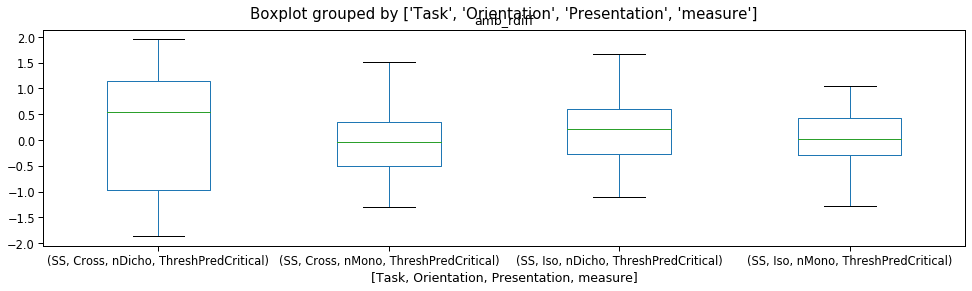

In [131]:
rdiffs_supp.boxplot(column='amb_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2769beb8>,
      dtype=object)

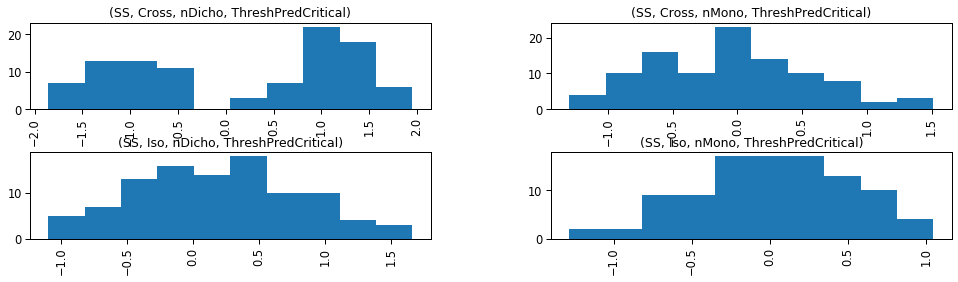

In [132]:
# Rho(GABA vs ThreshElev(NDE)) - Rho(GABA vs ThreshElev(DE)) for Amblyopes only, by condition
rdiffs_supp.hist(column='amb_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

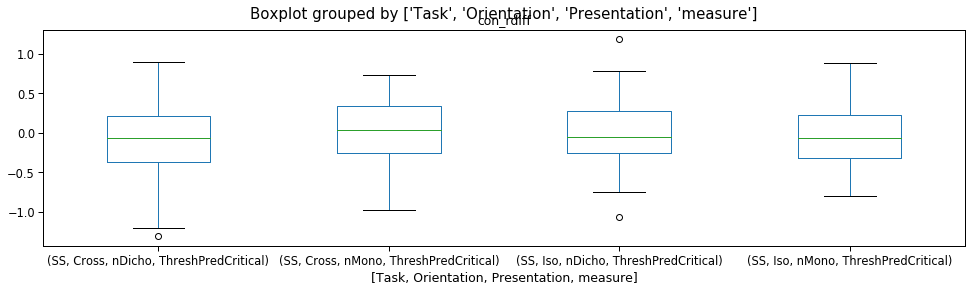

In [133]:
rdiffs_supp.boxplot(column='con_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

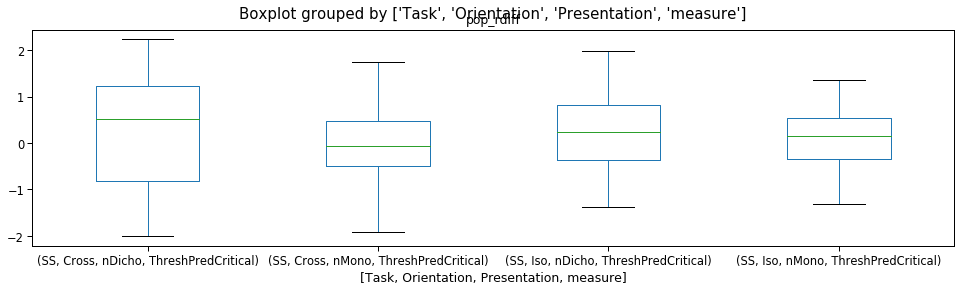

In [134]:
rdiffs_supp.boxplot(column='pop_rdiff', by=['Task','Orientation','Presentation','measure'],
               grid=False, figsize=(16, 4))

In [135]:
comb_gabappsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value,GABA
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,0.546837,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,0.992124,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,0.930127,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,0.988296,BaselineThresh,6.536,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,0.865440,BaselineThresh,4.764,0.201


In [136]:
spearman_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,rsquared,measure,value,GABA
33,SS,Cross,nDicho,Amblyope,bi,De,"Persons with\nAmblyopia, DE",0.546837,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,"Persons with\nAmblyopia, NDE",0.992124,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,"Persons with\nAmblyopia, NDE",0.930127,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,"Persons with\nAmblyopia, NDE",0.988296,BaselineThresh,6.536,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,"Persons with\nAmblyopia, NDE",0.865440,BaselineThresh,4.764,0.201


In [137]:
spearman_df.measure.unique()

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [138]:
kelly_file = f"{plot_dir}/{task}_data_frame.csv"
spearman_df.to_csv(kelly_file)

### Orientation Selective Suppression

In [139]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace",
             "measure", "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", 
             "measure", "GABA"]

In [140]:
for gv, g in spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(oss_gvars):
    print(gv, g.Orientation.unique())

('SS', 'nDicho', 'Amblyope', 'bi', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.205) ['Cross']
('SS', 'nDicho', 'Amblyope', 'bi', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.205) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'em', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.185) ['Iso']
('SS', 'nDicho', 'Amblyope', 'em', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.185) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'gd', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.19699999999999998) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'jv', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.201) ['Iso']
('SS', 'nDicho', 'Amblyope', 'jv', 'Nde', 'Persons with\nAmblyopia, NDE', 'ThreshPredCritical', 0.201) ['Cross']
('SS', 'nDicho', 'Amblyope', 'li', 'De', 'Persons with\nAmblyopia, DE', 'ThreshPredCritical', 0.21600000000000003) ['Cross']
('SS', 'nDicho', 'Amblyope', 'li', 'Nde', 'Persons with\nAmbly

In [141]:
spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(['Task', 'Orientation', 'Presentation', 'Population','Eye'])['value'].describe()

count      mean       std  \
Task Orientation Presentation Population Eye                              
SS   Cross       nDicho       Amblyope   De     2.0  0.957207  0.095512   
                                         Nde    8.0  1.118438  0.602485   
                              Control    De    12.0  0.920188  0.222444   
                                         Nde   12.0  1.000823  0.214008   
                 nMono        Amblyope   De     6.0  0.845055  0.131815   
                                         Nde    5.0  0.969276  0.211546   
                              Control    De    12.0  0.763950  0.153710   
                                         Nde   14.0  0.773161  0.159849   
     Iso         nDicho       Amblyope   De     5.0  0.826099  0.143298   
                                         Nde    7.0  1.210034  0.525613   
                              Control    De    13.0  1.162128  0.526390   
                                         Nde   14.0  1.299467  0.409784   
                 nMono        Amblyope   De     8.0  0.866610  0.216900   
                                         Nde    7.0  0.974545  0.213291   
                              Control    De    14.0  0.759316  0.205264   
                                         Nde   14.0  0.791336  0.181914   

                                                   min       25%       50%  \
Task Orientation Presentation Population Eye                                 
SS   Cross       nDicho       Amblyope   De   0.889669  0.923438  0.957207   
                                         Nde  0.297554  0.855251  1.097689   
                              Control    De   0.566634  0.752102  0.902277   
                                         Nde  0.710565  0.836442  0.987619   
                 nMono        Amblyope   De   0.618131  0.808101  0.855103   
                                         Nde  0.601685  0.988664  1.047289   
                              Control    De   0.531982  0.659041  0.782763   
                                         Nde  0.469253  0.707193  0.755307   
     Iso         nDicho       Amblyope   De   0.683123  0.722384  0.788769   
                                         Nde  0.454030  0.906793  1.282176   
                              Control    De   0.180381  0.877780  1.097869   
                                         Nde  0.833085  0.986137  1.285265   
                 nMono        Amblyope   De   0.572492  0.657065  0.920236   
                                         Nde  0.606465  0.878960  1.045415   
                              Control    De   0.472317  0.610172  0.750564   
                                         Nde  0.506221  0.678647  0.748844   

                                                   75%       max  
Task Orientation Presentation Population Eye                      
SS   Cross       nDicho       Amblyope   De   0.990975  1.024744  
                                         Nde  1.226792  2.367282  
                              Control    De   1.116148  1.198372  
                                         Nde  1.092446  1.458876  
                 nMono        Amblyope   De   0.941145  0.979736  
                                         Nde  1.082916  1.125824  
                              Control    De   0.853101  1.040694  
                                         Nde  0.896052  0.976262  
     Iso         nDicho       Amblyope   De   0.900248  1.035972  
                                         Nde  1.418028  2.084390  
                              Control    De   1.501505  2.191057  
                                         Nde  1.340348  2.269123  
                 nMono        Amblyope   De   1.014116  1.160384  
                                         Nde  1.119914  1.172186  
                              Control    De   0.924252  1.102926  
                                         Nde  0.869298  1.233350

In [142]:
spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(['Task', 'Presentation', 'Population','Eye'])['Subject'].describe()

count unique top freq
Task Presentation Population Eye                      
SS   nDicho       Amblyope   De      7      7  em    1
                             Nde    15      8  em    2
                  Control    De     25     14  gm    2
                             Nde    26     14  gm    2
     nMono        Amblyope   De     14      8  em    2
                             Nde    12      7  em    2
                  Control    De     26     14  gm    2
                             Nde    28     14  mk    2

In [143]:
oss_df = spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(oss_gvars).apply(utils.calculate_orientation_selective_suppression).reset_index()

Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0805794306213783
Iso/Cross ratio: nan
Iso/Cross ratio: 0.8804992773062317
Iso/Cross ratio: 1.6746546243888554
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 0.3777062353868689
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2225842451824867
Iso/Cross ratio: nan
Iso/Cross ratio: 0.9855669521500559
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0054249110747602
Iso/Cross ratio: 1.441081746125601
Iso/Cross ratio: 1.4101357218055621
Iso/Cross ratio: 0.3183386415959459
Iso/Cross ratio: 0.7860277350761017
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0334808785607723
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2625513903058483
Iso/Cross ratio: 1.3991192980351077
Iso/Cross ratio: 1.1074330346930361
Iso/Cross ratio: 1.4973547772549172
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2271654371200194
Iso/Cross ratio: 1.2351557611759358
Iso/Cross ratio: nan
Iso/Cross ratio: 2.2838663786421733
Iso/Cross ratio: 1.121263370574786
Iso/Cross

In [144]:
print(np.count_nonzero(np.isnan(oss_df.value)), len(oss_df.value))

11901 11968


In [145]:
oss_df.head(n=15)

,Task,Presentation,Population,Subject,Eye,Trace,measure,GABA,value
0,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.185,NaN
1,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.187,NaN
2,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.193,NaN
3,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.194,NaN
4,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.196,NaN
5,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.197,NaN
6,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.200,NaN
7,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.201,NaN
8,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.203,NaN
9,SS,nDicho,Amblyope,ai,De,"Persons with\nAmblyopia, DE",ThreshPredCritical,0.205,NaN


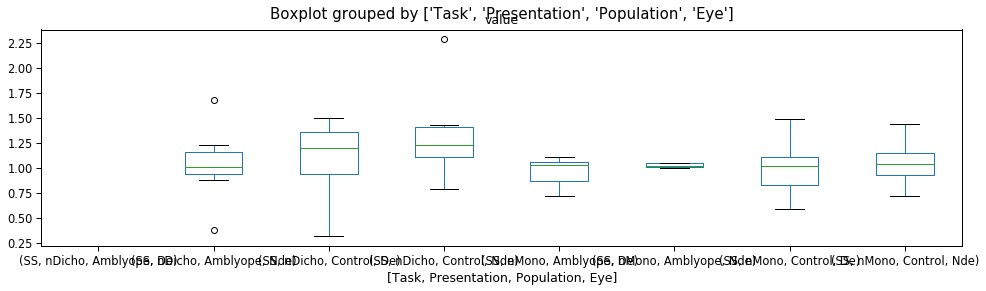

In [146]:
oss_df.boxplot(column='value', by=['Task','Presentation','Population','Eye'],
               grid=False, figsize=(16, 4))

In [147]:
oss_df.groupby(['Task', 'Presentation', 'Population','Eye'])['value'].describe()

count      mean       std       min  \
Task Presentation Population Eye                                        
SS   nDicho       Amblyope   De     0.0       NaN       NaN       NaN   
                             Nde    7.0  1.032431  0.388502  0.377706   
                  Control    De    11.0  1.116649  0.338898  0.318339   
                             Nde   12.0  1.287269  0.362879  0.786028   
     nMono        Amblyope   De     6.0  0.957098  0.157721  0.711143   
                             Nde    5.0  1.022666  0.021424  0.998211   
                  Control    De    12.0  0.991415  0.257819  0.580772   
                             Nde   14.0  1.039529  0.195072  0.715935   

                                       25%       50%       75%       max  
Task Presentation Population Eye                                          
SS   nDicho       Amblyope   De        NaN       NaN       NaN       NaN  
                             Nde  0.933033  1.005425  1.151582  1.674655  
                  Control    De   0.940048  1.200049  1.360375  1.497355  
                             Nde  1.105861  1.224489  1.411019  2.283866  
     nMono        Amblyope   De   0.864115  1.024349  1.054112  1.108008  
                             Nde  1.007945  1.017751  1.041180  1.048243  
                  Control    De   0.828919  1.014599  1.105571  1.486312  
                             Nde  0.927263  1.035547  1.143886  1.440743

In [148]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population','Eye']):
    print(gv)#, g, sep='\n')
    print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))

('SS', 'nDicho', 'Amblyope', 'De')
Ttest_1sampResult(statistic=masked, pvalue=masked)
('SS', 'nDicho', 'Amblyope', 'Nde')
Ttest_1sampResult(statistic=0.22085843740820543, pvalue=0.8325265415663132)
('SS', 'nDicho', 'Control', 'De')
Ttest_1sampResult(statistic=1.141589374533609, pvalue=0.2802239650794021)
('SS', 'nDicho', 'Control', 'Nde')
Ttest_1sampResult(statistic=2.742316292996574, pvalue=0.019151968328478295)
('SS', 'nMono', 'Amblyope', 'De')
Ttest_1sampResult(statistic=-0.6662954676462207, pvalue=0.5347275413950384)
('SS', 'nMono', 'Amblyope', 'Nde')
Ttest_1sampResult(statistic=2.365729454004665, pvalue=0.07717923918905874)
('SS', 'nMono', 'Control', 'De')
Ttest_1sampResult(statistic=-0.1153509834772772, pvalue=0.9102457072174562)
('SS', 'nMono', 'Control', 'Nde')
Ttest_1sampResult(statistic=0.7581942121706292, pvalue=0.46185931620148535)


In [149]:
def tt_pval(df):
    ttr = st.ttest_1samp(df['value'], popmean=1, nan_policy='omit')
    pval = ttr.pvalue
    return pd.Series(pval, ['pvalue'])

In [150]:
for gv, g in oss_df.groupby(['Task', 'Presentation', 'Population']):
    print(gv, len(g['value']))#, g, sep='\n')
    print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))

('SS', 'nDicho', 'Amblyope') 2992
Ttest_1sampResult(statistic=0.22085843740820543, pvalue=0.8325265415663132)
('SS', 'nDicho', 'Control') 2992
Ttest_1sampResult(statistic=2.782704722479271, pvalue=0.01085313691378986)
('SS', 'nMono', 'Amblyope') 2992
Ttest_1sampResult(statistic=-0.36989230153433034, pvalue=0.7191760785333314)
('SS', 'nMono', 'Control') 2992
Ttest_1sampResult(statistic=0.39646611393958797, pvalue=0.6951251229206845)


In [151]:
pvals_oss = oss_df.groupby(['Task', 'Presentation', 'Population']).apply(tt_pval)

In [152]:
mt.multipletests(pvals_oss.pvalue, 0.05, 'bonferroni')

(array([False,  True, False, False]),
 array([1.   , 0.043, 1.   , 1.   ]),
 0.012741455098566168,
 0.0125)

In [153]:
mt.multipletests(pvals_oss.pvalue, 0.05, 'fdr_bh')

(array([False,  True, False, False]),
 array([0.833, 0.043, 0.833, 0.833]),
 0.012741455098566168,
 0.0125)

In [154]:
for gv, g in oss_df.groupby(['Task', 'Presentation']):
    print(gv, len(g['value']))#, g, sep='\n')
    print(st.ttest_1samp(g['value'], popmean=1, nan_policy='omit'))

('SS', 'nDicho') 5984
Ttest_1sampResult(statistic=2.490288439286957, pvalue=0.018740833697331365)
('SS', 'nMono') 5984
Ttest_1sampResult(statistic=0.25663782267059304, pvalue=0.798919411699752)


In [155]:
oss_df.groupby(['Task', 'Presentation', 'Population'])['value'].describe()

count      mean       std       min       25%  \
Task Presentation Population                                                  
SS   nDicho       Amblyope      7.0  1.032431  0.388502  0.377706  0.933033   
                  Control      23.0  1.205668  0.354458  0.318339  1.067312   
     nMono        Amblyope     11.0  0.986901  0.117448  0.711143  1.003078   
                  Control      26.0  1.017322  0.222785  0.580772  0.864030   

                                   50%       75%       max  
Task Presentation Population                                
SS   nDicho       Amblyope    1.005425  1.151582  1.674655  
                  Control     1.213822  1.404628  2.283866  
     nMono        Amblyope    1.019271  1.044711  1.108008  
                  Control     1.035547  1.139274  1.486312

In [156]:
oss_dicho = oss_df[oss_df.Presentation=="nDicho"]['value']
oss_mono = oss_df[oss_df.Presentation=="nMono"]['value']

In [157]:
st.ttest_ind(oss_dicho, oss_mono, nan_policy='omit', equal_var=False)

Ttest_indResult(statistic=2.1274860727815303, pvalue=0.039235178895599625)

In [158]:
def oss_mean_combeyes(df, **kwargs):
    if len(df.Eye.unique())==2:
        v1 = df[df.Eye=='Nde']['value'].iloc[0]
        v2 = df[df.Eye=='De']['value'].iloc[0]
        oss_mean_combeyes = np.mean([v1, v2])
    else:
        oss_mean_combeyes = np.nan
    print(f"OSS mean across eyes: {oss_mean_combeyes}")
    return pd.Series(oss_mean_combeyes, ['value'])

In [159]:
for gv, g in oss_df.groupby(oss_gvars_combeyes):
    print(gv, g, sep="\n")

('SS', 'nDicho', 'Amblyope', 'ai', 'ThreshPredCritical', 0.185)
    Task Presentation Population Subject  Eye                           Trace  \
0     SS       nDicho   Amblyope      ai   De     Persons with\nAmblyopia, DE   
17    SS       nDicho   Amblyope      ai   De    Persons with\nAmblyopia, NDE   
34    SS       nDicho   Amblyope      ai   De   Normally-sighted\npersons, DE   
51    SS       nDicho   Amblyope      ai   De  Normally-sighted\npersons, NDE   
68    SS       nDicho   Amblyope      ai  Nde     Persons with\nAmblyopia, DE   
85    SS       nDicho   Amblyope      ai  Nde    Persons with\nAmblyopia, NDE   
102   SS       nDicho   Amblyope      ai  Nde   Normally-sighted\npersons, DE   
119   SS       nDicho   Amblyope      ai  Nde  Normally-sighted\npersons, NDE   

                measure   GABA  value  
0    ThreshPredCritical  0.185    NaN  
17   ThreshPredCritical  0.185    NaN  
34   ThreshPredCritical  0.185    NaN  
51   ThreshPredCritical  0.185    NaN  
68   T

('SS', 'nDicho', 'Amblyope', 'bi', 'ThreshPredCritical', 0.21100000000000002)
    Task Presentation Population Subject  Eye                           Trace  \
148   SS       nDicho   Amblyope      bi   De     Persons with\nAmblyopia, DE   
165   SS       nDicho   Amblyope      bi   De    Persons with\nAmblyopia, NDE   
182   SS       nDicho   Amblyope      bi   De   Normally-sighted\npersons, DE   
199   SS       nDicho   Amblyope      bi   De  Normally-sighted\npersons, NDE   
216   SS       nDicho   Amblyope      bi  Nde     Persons with\nAmblyopia, DE   
233   SS       nDicho   Amblyope      bi  Nde    Persons with\nAmblyopia, NDE   
250   SS       nDicho   Amblyope      bi  Nde   Normally-sighted\npersons, DE   
267   SS       nDicho   Amblyope      bi  Nde  Normally-sighted\npersons, NDE   

                measure   GABA  value  
148  ThreshPredCritical  0.211    NaN  
165  ThreshPredCritical  0.211    NaN  
182  ThreshPredCritical  0.211    NaN  
199  ThreshPredCritical  0.211  

667  ThreshPredCritical  0.196    NaN  
('SS', 'nDicho', 'Amblyope', 'dl', 'ThreshPredCritical', 0.19699999999999998)
    Task Presentation Population Subject  Eye                           Trace  \
549   SS       nDicho   Amblyope      dl   De     Persons with\nAmblyopia, DE   
566   SS       nDicho   Amblyope      dl   De    Persons with\nAmblyopia, NDE   
583   SS       nDicho   Amblyope      dl   De   Normally-sighted\npersons, DE   
600   SS       nDicho   Amblyope      dl   De  Normally-sighted\npersons, NDE   
617   SS       nDicho   Amblyope      dl  Nde     Persons with\nAmblyopia, DE   
634   SS       nDicho   Amblyope      dl  Nde    Persons with\nAmblyopia, NDE   
651   SS       nDicho   Amblyope      dl  Nde   Normally-sighted\npersons, DE   
668   SS       nDicho   Amblyope      dl  Nde  Normally-sighted\npersons, NDE   

                measure   GABA  value  
549  ThreshPredCritical  0.197    NaN  
566  ThreshPredCritical  0.197    NaN  
583  ThreshPredCritical  0.197  

     Task Presentation Population Subject  Eye  \
956    SS       nDicho   Amblyope      es   De   
973    SS       nDicho   Amblyope      es   De   
990    SS       nDicho   Amblyope      es   De   
1007   SS       nDicho   Amblyope      es   De   
1024   SS       nDicho   Amblyope      es  Nde   
1041   SS       nDicho   Amblyope      es  Nde   
1058   SS       nDicho   Amblyope      es  Nde   
1075   SS       nDicho   Amblyope      es  Nde   

                               Trace             measure   GABA  value  
956      Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
973     Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
990    Normally-sighted\npersons, DE  ThreshPredCritical  0.196    NaN  
1007  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
1024     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
1041    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
1058   Normally-sighted\npersons, DE  

1353  Normally-sighted\npersons, NDE  ThreshPredCritical  0.208    NaN  
('SS', 'nDicho', 'Amblyope', 'gm', 'ThreshPredCritical', 0.21)
     Task Presentation Population Subject  Eye  \
1235   SS       nDicho   Amblyope      gm   De   
1252   SS       nDicho   Amblyope      gm   De   
1269   SS       nDicho   Amblyope      gm   De   
1286   SS       nDicho   Amblyope      gm   De   
1303   SS       nDicho   Amblyope      gm  Nde   
1320   SS       nDicho   Amblyope      gm  Nde   
1337   SS       nDicho   Amblyope      gm  Nde   
1354   SS       nDicho   Amblyope      gm  Nde   

                               Trace             measure  GABA  value  
1235     Persons with\nAmblyopia, DE  ThreshPredCritical  0.21    NaN  
1252    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.21    NaN  
1269   Normally-sighted\npersons, DE  ThreshPredCritical  0.21    NaN  
1286  Normally-sighted\npersons, NDE  ThreshPredCritical  0.21    NaN  
1303     Persons with\nAmblyopia, DE  ThreshPredCriti

     Task Presentation Population Subject  Eye  \
1646   SS       nDicho   Amblyope      kw   De   
1663   SS       nDicho   Amblyope      kw   De   
1680   SS       nDicho   Amblyope      kw   De   
1697   SS       nDicho   Amblyope      kw   De   
1714   SS       nDicho   Amblyope      kw  Nde   
1731   SS       nDicho   Amblyope      kw  Nde   
1748   SS       nDicho   Amblyope      kw  Nde   
1765   SS       nDicho   Amblyope      kw  Nde   

                               Trace             measure   GABA  value  
1646     Persons with\nAmblyopia, DE  ThreshPredCritical  0.217    NaN  
1663    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.217    NaN  
1680   Normally-sighted\npersons, DE  ThreshPredCritical  0.217    NaN  
1697  Normally-sighted\npersons, NDE  ThreshPredCritical  0.217    NaN  
1714     Persons with\nAmblyopia, DE  ThreshPredCritical  0.217    NaN  
1731    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.217    NaN  
1748   Normally-sighted\npersons, DE  

2171  Normally-sighted\npersons, NDE  ThreshPredCritical  0.211    NaN  
('SS', 'nDicho', 'Amblyope', 'mg', 'ThreshPredCritical', 0.21600000000000003)
     Task Presentation Population Subject  Eye  \
2053   SS       nDicho   Amblyope      mg   De   
2070   SS       nDicho   Amblyope      mg   De   
2087   SS       nDicho   Amblyope      mg   De   
2104   SS       nDicho   Amblyope      mg   De   
2121   SS       nDicho   Amblyope      mg  Nde   
2138   SS       nDicho   Amblyope      mg  Nde   
2155   SS       nDicho   Amblyope      mg  Nde   
2172   SS       nDicho   Amblyope      mg  Nde   

                               Trace             measure   GABA  value  
2053     Persons with\nAmblyopia, DE  ThreshPredCritical  0.216    NaN  
2070    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.216    NaN  
2087   Normally-sighted\npersons, DE  ThreshPredCritical  0.216    NaN  
2104  Normally-sighted\npersons, NDE  ThreshPredCritical  0.216    NaN  
2121     Persons with\nAmblyopia,

('SS', 'nDicho', 'Amblyope', 'yl', 'ThreshPredCritical', 0.185)
     Task Presentation Population Subject  Eye  \
2856   SS       nDicho   Amblyope      yl   De   
2873   SS       nDicho   Amblyope      yl   De   
2890   SS       nDicho   Amblyope      yl   De   
2907   SS       nDicho   Amblyope      yl   De   
2924   SS       nDicho   Amblyope      yl  Nde   
2941   SS       nDicho   Amblyope      yl  Nde   
2958   SS       nDicho   Amblyope      yl  Nde   
2975   SS       nDicho   Amblyope      yl  Nde   

                               Trace             measure   GABA  value  
2856     Persons with\nAmblyopia, DE  ThreshPredCritical  0.185    NaN  
2873    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.185    NaN  
2890   Normally-sighted\npersons, DE  ThreshPredCritical  0.185    NaN  
2907  Normally-sighted\npersons, NDE  ThreshPredCritical  0.185    NaN  
2924     Persons with\nAmblyopia, DE  ThreshPredCritical  0.185    NaN  
2941    Persons with\nAmblyopia, NDE  ThreshPre

     Task Presentation Population Subject  Eye  \
3268   SS       nDicho    Control      cr   De   
3285   SS       nDicho    Control      cr   De   
3302   SS       nDicho    Control      cr   De   
3319   SS       nDicho    Control      cr   De   
3336   SS       nDicho    Control      cr  Nde   
3353   SS       nDicho    Control      cr  Nde   
3370   SS       nDicho    Control      cr  Nde   
3387   SS       nDicho    Control      cr  Nde   

                               Trace             measure   GABA  value  
3268     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
3285    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
3302   Normally-sighted\npersons, DE  ThreshPredCritical  0.196    NaN  
3319  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
3336     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
3353    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
3370   Normally-sighted\npersons, DE  

3941  Normally-sighted\npersons, NDE  ThreshPredCritical  0.217    NaN  
('SS', 'nDicho', 'Control', 'em', 'ThreshPredCritical', 0.22)
     Task Presentation Population Subject  Eye  \
3823   SS       nDicho    Control      em   De   
3840   SS       nDicho    Control      em   De   
3857   SS       nDicho    Control      em   De   
3874   SS       nDicho    Control      em   De   
3891   SS       nDicho    Control      em  Nde   
3908   SS       nDicho    Control      em  Nde   
3925   SS       nDicho    Control      em  Nde   
3942   SS       nDicho    Control      em  Nde   

                               Trace             measure  GABA  value  
3823     Persons with\nAmblyopia, DE  ThreshPredCritical  0.22    NaN  
3840    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.22    NaN  
3857   Normally-sighted\npersons, DE  ThreshPredCritical  0.22    NaN  
3874  Normally-sighted\npersons, NDE  ThreshPredCritical  0.22    NaN  
3891     Persons with\nAmblyopia, DE  ThreshPredCritic

4483  Normally-sighted\npersons, NDE  ThreshPredCritical  0.211    NaN  
('SS', 'nDicho', 'Control', 'jd', 'ThreshPredCritical', 0.21600000000000003)
     Task Presentation Population Subject  Eye  \
4365   SS       nDicho    Control      jd   De   
4382   SS       nDicho    Control      jd   De   
4399   SS       nDicho    Control      jd   De   
4416   SS       nDicho    Control      jd   De   
4433   SS       nDicho    Control      jd  Nde   
4450   SS       nDicho    Control      jd  Nde   
4467   SS       nDicho    Control      jd  Nde   
4484   SS       nDicho    Control      jd  Nde   

                               Trace             measure   GABA  value  
4365     Persons with\nAmblyopia, DE  ThreshPredCritical  0.216    NaN  
4382    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.216    NaN  
4399   Normally-sighted\npersons, DE  ThreshPredCritical  0.216    NaN  
4416  Normally-sighted\npersons, NDE  ThreshPredCritical  0.216    NaN  
4433     Persons with\nAmblyopia, 

     Task Presentation Population Subject  Eye  \
4900   SS       nDicho    Control      ls   De   
4917   SS       nDicho    Control      ls   De   
4934   SS       nDicho    Control      ls   De   
4951   SS       nDicho    Control      ls   De   
4968   SS       nDicho    Control      ls  Nde   
4985   SS       nDicho    Control      ls  Nde   
5002   SS       nDicho    Control      ls  Nde   
5019   SS       nDicho    Control      ls  Nde   

                               Trace             measure   GABA  value  
4900     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
4917    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
4934   Normally-sighted\npersons, DE  ThreshPredCritical  0.196    NaN  
4951  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
4968     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
4985    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
5002   Normally-sighted\npersons, DE  

5439  Normally-sighted\npersons, NDE  ThreshPredCritical  0.223    NaN  
('SS', 'nDicho', 'Control', 'nl', 'ThreshPredCritical', 0.185)
     Task Presentation Population Subject  Eye  \
5440   SS       nDicho    Control      nl   De   
5457   SS       nDicho    Control      nl   De   
5474   SS       nDicho    Control      nl   De   
5491   SS       nDicho    Control      nl   De   
5508   SS       nDicho    Control      nl  Nde   
5525   SS       nDicho    Control      nl  Nde   
5542   SS       nDicho    Control      nl  Nde   
5559   SS       nDicho    Control      nl  Nde   

                               Trace             measure   GABA  value  
5440     Persons with\nAmblyopia, DE  ThreshPredCritical  0.185    NaN  
5457    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.185    NaN  
5474   Normally-sighted\npersons, DE  ThreshPredCritical  0.185    NaN  
5491  Normally-sighted\npersons, NDE  ThreshPredCritical  0.185    NaN  
5508     Persons with\nAmblyopia, DE  ThreshPred

5969  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
('SS', 'nDicho', 'Control', 'yl', 'ThreshPredCritical', 0.19399999999999998)
     Task Presentation Population Subject  Eye  \
5851   SS       nDicho    Control      yl   De   
5868   SS       nDicho    Control      yl   De   
5885   SS       nDicho    Control      yl   De   
5902   SS       nDicho    Control      yl   De   
5919   SS       nDicho    Control      yl  Nde   
5936   SS       nDicho    Control      yl  Nde   
5953   SS       nDicho    Control      yl  Nde   
5970   SS       nDicho    Control      yl  Nde   

                               Trace             measure   GABA  value  
5851     Persons with\nAmblyopia, DE  ThreshPredCritical  0.194    NaN  
5868    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.194    NaN  
5885   Normally-sighted\npersons, DE  ThreshPredCritical  0.194    NaN  
5902  Normally-sighted\npersons, NDE  ThreshPredCritical  0.194    NaN  
5919     Persons with\nAmblyopia, 

6376  Normally-sighted\npersons, NDE  ThreshPredCritical  0.187    NaN  
('SS', 'nMono', 'Amblyope', 'cr', 'ThreshPredCritical', 0.193)
     Task Presentation Population Subject  Eye  \
6258   SS        nMono   Amblyope      cr   De   
6275   SS        nMono   Amblyope      cr   De   
6292   SS        nMono   Amblyope      cr   De   
6309   SS        nMono   Amblyope      cr   De   
6326   SS        nMono   Amblyope      cr  Nde   
6343   SS        nMono   Amblyope      cr  Nde   
6360   SS        nMono   Amblyope      cr  Nde   
6377   SS        nMono   Amblyope      cr  Nde   

                               Trace             measure   GABA  value  
6258     Persons with\nAmblyopia, DE  ThreshPredCritical  0.193    NaN  
6275    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.193    NaN  
6292   Normally-sighted\npersons, DE  ThreshPredCritical  0.193    NaN  
6309  Normally-sighted\npersons, NDE  ThreshPredCritical  0.193    NaN  
6326     Persons with\nAmblyopia, DE  ThreshPred

6783  Normally-sighted\npersons, NDE  ThreshPredCritical  0.185    NaN  
('SS', 'nMono', 'Amblyope', 'ei', 'ThreshPredCritical', 0.187)
     Task Presentation Population Subject  Eye  \
6665   SS        nMono   Amblyope      ei   De   
6682   SS        nMono   Amblyope      ei   De   
6699   SS        nMono   Amblyope      ei   De   
6716   SS        nMono   Amblyope      ei   De   
6733   SS        nMono   Amblyope      ei  Nde   
6750   SS        nMono   Amblyope      ei  Nde   
6767   SS        nMono   Amblyope      ei  Nde   
6784   SS        nMono   Amblyope      ei  Nde   

                               Trace             measure   GABA  value  
6665     Persons with\nAmblyopia, DE  ThreshPredCritical  0.187    NaN  
6682    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.187    NaN  
6699   Normally-sighted\npersons, DE  ThreshPredCritical  0.187    NaN  
6716  Normally-sighted\npersons, NDE  ThreshPredCritical  0.187    NaN  
6733     Persons with\nAmblyopia, DE  ThreshPred

7197  Normally-sighted\npersons, NDE  ThreshPredCritical   0.2    NaN  
('SS', 'nMono', 'Amblyope', 'gd', 'ThreshPredCritical', 0.201)
     Task Presentation Population Subject  Eye  \
7079   SS        nMono   Amblyope      gd   De   
7096   SS        nMono   Amblyope      gd   De   
7113   SS        nMono   Amblyope      gd   De   
7130   SS        nMono   Amblyope      gd   De   
7147   SS        nMono   Amblyope      gd  Nde   
7164   SS        nMono   Amblyope      gd  Nde   
7181   SS        nMono   Amblyope      gd  Nde   
7198   SS        nMono   Amblyope      gd  Nde   

                               Trace             measure   GABA  value  
7079     Persons with\nAmblyopia, DE  ThreshPredCritical  0.201    NaN  
7096    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.201    NaN  
7113   Normally-sighted\npersons, DE  ThreshPredCritical  0.201    NaN  
7130  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
7147     Persons with\nAmblyopia, DE  ThreshPredC

7746  Normally-sighted\npersons, NDE  ThreshPredCritical  0.21    NaN  
('SS', 'nMono', 'Amblyope', 'kw', 'ThreshPredCritical', 0.21100000000000002)
     Task Presentation Population Subject  Eye  \
7628   SS        nMono   Amblyope      kw   De   
7645   SS        nMono   Amblyope      kw   De   
7662   SS        nMono   Amblyope      kw   De   
7679   SS        nMono   Amblyope      kw   De   
7696   SS        nMono   Amblyope      kw  Nde   
7713   SS        nMono   Amblyope      kw  Nde   
7730   SS        nMono   Amblyope      kw  Nde   
7747   SS        nMono   Amblyope      kw  Nde   

                               Trace             measure   GABA  value  
7628     Persons with\nAmblyopia, DE  ThreshPredCritical  0.211    NaN  
7645    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.211    NaN  
7662   Normally-sighted\npersons, DE  ThreshPredCritical  0.211    NaN  
7679  Normally-sighted\npersons, NDE  ThreshPredCritical  0.211    NaN  
7696     Persons with\nAmblyopia, D

8150  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
('SS', 'nMono', 'Amblyope', 'mg', 'ThreshPredCritical', 0.203)
     Task Presentation Population Subject  Eye  \
8032   SS        nMono   Amblyope      mg   De   
8049   SS        nMono   Amblyope      mg   De   
8066   SS        nMono   Amblyope      mg   De   
8083   SS        nMono   Amblyope      mg   De   
8100   SS        nMono   Amblyope      mg  Nde   
8117   SS        nMono   Amblyope      mg  Nde   
8134   SS        nMono   Amblyope      mg  Nde   
8151   SS        nMono   Amblyope      mg  Nde   

                               Trace             measure   GABA  value  
8032     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
8049    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
8066   Normally-sighted\npersons, DE  ThreshPredCritical  0.203    NaN  
8083  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
8100     Persons with\nAmblyopia, DE  ThreshPred

8559  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
('SS', 'nMono', 'Amblyope', 'nl', 'ThreshPredCritical', 0.205)
     Task Presentation Population Subject  Eye  \
8441   SS        nMono   Amblyope      nl   De   
8458   SS        nMono   Amblyope      nl   De   
8475   SS        nMono   Amblyope      nl   De   
8492   SS        nMono   Amblyope      nl   De   
8509   SS        nMono   Amblyope      nl  Nde   
8526   SS        nMono   Amblyope      nl  Nde   
8543   SS        nMono   Amblyope      nl  Nde   
8560   SS        nMono   Amblyope      nl  Nde   

                               Trace             measure   GABA  value  
8441     Persons with\nAmblyopia, DE  ThreshPredCritical  0.205    NaN  
8458    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.205    NaN  
8475   Normally-sighted\npersons, DE  ThreshPredCritical  0.205    NaN  
8492  Normally-sighted\npersons, NDE  ThreshPredCritical  0.205    NaN  
8509     Persons with\nAmblyopia, DE  ThreshPred

8974  Normally-sighted\npersons, NDE  ThreshPredCritical  0.22    NaN  
('SS', 'nMono', 'Amblyope', 'yl', 'ThreshPredCritical', 0.223)
     Task Presentation Population Subject  Eye  \
8856   SS        nMono   Amblyope      yl   De   
8873   SS        nMono   Amblyope      yl   De   
8890   SS        nMono   Amblyope      yl   De   
8907   SS        nMono   Amblyope      yl   De   
8924   SS        nMono   Amblyope      yl  Nde   
8941   SS        nMono   Amblyope      yl  Nde   
8958   SS        nMono   Amblyope      yl  Nde   
8975   SS        nMono   Amblyope      yl  Nde   

                               Trace             measure   GABA  value  
8856     Persons with\nAmblyopia, DE  ThreshPredCritical  0.223    NaN  
8873    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.223    NaN  
8890   Normally-sighted\npersons, DE  ThreshPredCritical  0.223    NaN  
8907  Normally-sighted\npersons, NDE  ThreshPredCritical  0.223    NaN  
8924     Persons with\nAmblyopia, DE  ThreshPredC

9508  Normally-sighted\npersons, NDE  ThreshPredCritical  0.197    NaN  
('SS', 'nMono', 'Control', 'ct', 'ThreshPredCritical', 0.2)
     Task Presentation Population Subject  Eye  \
9390   SS        nMono    Control      ct   De   
9407   SS        nMono    Control      ct   De   
9424   SS        nMono    Control      ct   De   
9441   SS        nMono    Control      ct   De   
9458   SS        nMono    Control      ct  Nde   
9475   SS        nMono    Control      ct  Nde   
9492   SS        nMono    Control      ct  Nde   
9509   SS        nMono    Control      ct  Nde   

                               Trace             measure  GABA  value  
9390     Persons with\nAmblyopia, DE  ThreshPredCritical   0.2    NaN  
9407    Persons with\nAmblyopia, NDE  ThreshPredCritical   0.2    NaN  
9424   Normally-sighted\npersons, DE  ThreshPredCritical   0.2    NaN  
9441  Normally-sighted\npersons, NDE  ThreshPredCritical   0.2    NaN  
9458     Persons with\nAmblyopia, DE  ThreshPredCritical

9918  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
('SS', 'nMono', 'Control', 'em', 'ThreshPredCritical', 0.203)
     Task Presentation Population Subject  Eye  \
9800   SS        nMono    Control      em   De   
9817   SS        nMono    Control      em   De   
9834   SS        nMono    Control      em   De   
9851   SS        nMono    Control      em   De   
9868   SS        nMono    Control      em  Nde   
9885   SS        nMono    Control      em  Nde   
9902   SS        nMono    Control      em  Nde   
9919   SS        nMono    Control      em  Nde   

                               Trace             measure   GABA  value  
9800     Persons with\nAmblyopia, DE  ThreshPredCritical  0.203    NaN  
9817    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.203    NaN  
9834   Normally-sighted\npersons, DE  ThreshPredCritical  0.203    NaN  
9851  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
9868     Persons with\nAmblyopia, DE  ThreshPredC

10461  Normally-sighted\npersons, NDE  ThreshPredCritical   0.2    NaN  
('SS', 'nMono', 'Control', 'jd', 'ThreshPredCritical', 0.201)
      Task Presentation Population Subject  Eye  \
10343   SS        nMono    Control      jd   De   
10360   SS        nMono    Control      jd   De   
10377   SS        nMono    Control      jd   De   
10394   SS        nMono    Control      jd   De   
10411   SS        nMono    Control      jd  Nde   
10428   SS        nMono    Control      jd  Nde   
10445   SS        nMono    Control      jd  Nde   
10462   SS        nMono    Control      jd  Nde   

                                Trace             measure   GABA  value  
10343     Persons with\nAmblyopia, DE  ThreshPredCritical  0.201    NaN  
10360    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.201    NaN  
10377   Normally-sighted\npersons, DE  ThreshPredCritical  0.201    NaN  
10394  Normally-sighted\npersons, NDE  ThreshPredCritical  0.201    NaN  
10411     Persons with\nAmblyopia, 

10871  Normally-sighted\npersons, NDE  ThreshPredCritical  0.203    NaN  
('SS', 'nMono', 'Control', 'li', 'ThreshPredCritical', 0.205)
      Task Presentation Population Subject  Eye  \
10753   SS        nMono    Control      li   De   
10770   SS        nMono    Control      li   De   
10787   SS        nMono    Control      li   De   
10804   SS        nMono    Control      li   De   
10821   SS        nMono    Control      li  Nde   
10838   SS        nMono    Control      li  Nde   
10855   SS        nMono    Control      li  Nde   
10872   SS        nMono    Control      li  Nde   

                                Trace             measure   GABA  value  
10753     Persons with\nAmblyopia, DE  ThreshPredCritical  0.205    NaN  
10770    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.205    NaN  
10787   Normally-sighted\npersons, DE  ThreshPredCritical  0.205    NaN  
10804  Normally-sighted\npersons, NDE  ThreshPredCritical  0.205    NaN  
10821     Persons with\nAmblyopia,

11275  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
('SS', 'nMono', 'Control', 'mk', 'ThreshPredCritical', 0.19699999999999998)
      Task Presentation Population Subject  Eye  \
11157   SS        nMono    Control      mk   De   
11174   SS        nMono    Control      mk   De   
11191   SS        nMono    Control      mk   De   
11208   SS        nMono    Control      mk   De   
11225   SS        nMono    Control      mk  Nde   
11242   SS        nMono    Control      mk  Nde   
11259   SS        nMono    Control      mk  Nde   
11276   SS        nMono    Control      mk  Nde   

                                Trace             measure   GABA     value  
11157     Persons with\nAmblyopia, DE  ThreshPredCritical  0.197       NaN  
11174    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.197       NaN  
11191   Normally-sighted\npersons, DE  ThreshPredCritical  0.197  0.648440  
11208  Normally-sighted\npersons, NDE  ThreshPredCritical  0.197       NaN  
11225

11682  Normally-sighted\npersons, NDE  ThreshPredCritical  0.194    NaN  
('SS', 'nMono', 'Control', 'rn', 'ThreshPredCritical', 0.196)
      Task Presentation Population Subject  Eye  \
11564   SS        nMono    Control      rn   De   
11581   SS        nMono    Control      rn   De   
11598   SS        nMono    Control      rn   De   
11615   SS        nMono    Control      rn   De   
11632   SS        nMono    Control      rn  Nde   
11649   SS        nMono    Control      rn  Nde   
11666   SS        nMono    Control      rn  Nde   
11683   SS        nMono    Control      rn  Nde   

                                Trace             measure   GABA  value  
11564     Persons with\nAmblyopia, DE  ThreshPredCritical  0.196    NaN  
11581    Persons with\nAmblyopia, NDE  ThreshPredCritical  0.196    NaN  
11598   Normally-sighted\npersons, DE  ThreshPredCritical  0.196    NaN  
11615  Normally-sighted\npersons, NDE  ThreshPredCritical  0.196    NaN  
11632     Persons with\nAmblyopia,

In [160]:
oss_df_combeyes = oss_df.groupby(oss_gvars_combeyes).apply(oss_mean_combeyes).reset_index()

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean acr

In [161]:
oss_df_combeyes

,Task,Presentation,Population,Subject,measure,GABA,value
0,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.185,NaN
1,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.187,NaN
2,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.193,NaN
3,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.194,NaN
4,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.196,NaN
5,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.197,NaN
6,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.200,NaN
7,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.201,NaN
8,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.203,NaN
9,SS,nDicho,Amblyope,ai,ThreshPredCritical,0.205,NaN


In [162]:
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_oss.pdf") as pdf:
    temp_df = oss_df.copy()
    temp_df['Eye'] = temp_df['Eye'].astype('category')
    plot_groups = temp_df.groupby(['Task', 'Presentation', 'Population','measure'])
    for gv, gr in plot_groups:
        #if "BaselineThresh" in gv: continue
        if "Amblyope" in gv:
            pal = colors_a
        elif "Control" in gv:
            pal = colors_c
        else:
            print('Error! neither amb nor con!')
        print(gv, np.all(np.isnan(gr['value'])))
        g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'nDicho', 'Amblyope', 'ThreshPredCritical') False
('SS', 'nDicho', 'Control', 'ThreshPredCritical') False
('SS', 'nMono', 'Amblyope', 'ThreshPredCritical') False
('SS', 'nMono', 'Control', 'ThreshPredCritical') False


In [163]:
# with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_oss_combeyes.pdf") as pdf:
#     temp_df = oss_df_combeyes.copy()
#     plot_groups = temp_df.groupby(['Task', 'Presentation', 'Population','measure'])
#     for gv, gr in plot_groups:
#         #if "BaselineThresh" in gv: continue
#         if "Amblyope" in gv:
#             pal = colors_a
#             print(gv, np.all(np.isnan(gr['value'])))
#         elif "Control" in gv:
#             pal = colors_c
#             print(gv, np.all(np.isnan(gr['value'])),
#                   stats.spearmanr(gr.GABA, gr.value, nan_policy='omit'), sep='\n')
#         else:
#             print('Error! neither amb nor con!')
#         g2 = s.oss_plot_2eye(gv, gr, palette=pal)
#         pdf.savefig(g2.fig)
        
#     plt.close('all')

### Combine measures across the two eyes

 * Does it make sense to combine all measures across both eyes (i.e. by subtracting?) For example, ThreshElev is in units of baseline, and the baseline varies by eye. So perhaps only a few measures should be combined -- say, slope/yint, ThreshPredCriticalUnnorm. 

In [164]:
measures = comb_gabappsub[comb_gabappsub["measure"].isin(["BaselineThresh","ThreshPredCritical"])]

In [165]:
np.unique(measures.measure)

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [166]:
paired_obs = measures.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2: # this will exclude paired observations where there was no data for one eye
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])
    else:
        print(f"Skipping because one eye is missing...")

In [167]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye 

In [168]:
obs_diff[obs_diff.Subject=='em']

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De
2,SS,Cross,Amblyope,nDicho,em,BaselineThresh,NaN
3,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,NaN
18,SS,Cross,Amblyope,nMono,em,BaselineThresh,0.065000
19,SS,Cross,Amblyope,nMono,em,ThreshPredCritical,0.370533
88,SS,Iso,Amblyope,nDicho,em,BaselineThresh,0.065000
89,SS,Iso,Amblyope,nDicho,em,ThreshPredCritical,1.362006
104,SS,Iso,Amblyope,nMono,em,BaselineThresh,0.065000
105,SS,Iso,Amblyope,nMono,em,ThreshPredCritical,0.369893


In [169]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [170]:
comb_botheyes

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA
0,SS,Cross,Amblyope,nDicho,bi,BaselineThresh,2.314000,0.205
1,SS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,0.311639,0.205
2,SS,Cross,Amblyope,nDicho,em,BaselineThresh,NaN,0.185
3,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,NaN,0.185
4,SS,Cross,Amblyope,nDicho,gd,BaselineThresh,NaN,0.197
5,SS,Cross,Amblyope,nDicho,gd,ThreshPredCritical,NaN,0.197
6,SS,Cross,Amblyope,nDicho,jv,BaselineThresh,NaN,0.201
7,SS,Cross,Amblyope,nDicho,jv,ThreshPredCritical,NaN,0.201
8,SS,Cross,Amblyope,nDicho,li,BaselineThresh,3.253000,0.216
9,SS,Cross,Amblyope,nDicho,li,ThreshPredCritical,0.177329,0.216


In [171]:
print(len(np.unique(comb_botheyes.Subject)))

22


In [172]:
test_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','Population','measure'])
for gv, gr in test_groups:
    #print(gr.head())
    if gv[-1]=="ThreshPredCritical":
        print(gv)
        print(stats.spearmanr(gr.GABA, gr['Nde-De']))

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('SS', 'Iso', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.015401549473819522, pvalue=0.9583240025471578)


In [173]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'ThreshPredCritical')


In [174]:
# more graphs for presentation!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}_poster.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','measure'])
    for gv, gr in plot_groups:
        if gv[-2] in ["nDicho"]: # use this line to exclude measures we don't want
            print(gv)
            g2 = s.gaba_vs_psychophys_plot_2line_2eye_nofacet(gv, gr, hue="Population", height=5, aspect=1.2, legend=False)
            #print(g2.axes)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')


## Demographic stuff from KB

In [175]:
amb_data = demos[demos['group']==1]
amb_data['motorGABA'] = pd.to_numeric(amb_data['motorGABA'].str.strip(), errors='coerce')
amb_data[["numID","initials","labelGroup","labelNDE","swapNDE_EY","acuityDE","acuityNDE",
          "iadLogMAR","occGABA","motorGABA"]]

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,numID,initials,labelGroup,labelNDE,swapNDE_EY,acuityDE,acuityNDE,iadLogMAR,occGABA,motorGABA
0,1,ac,PWA,right,0,-0.204120,0.116910,0.321030,0.198,0.215
2,6,as,PWA,left,0,-0.097000,0.244000,0.341000,0.217,0.196
3,7,bi,PWA,right,0,-0.096910,0.417940,0.514850,0.205,0.219
4,9,ch,PWA,left,0,-0.084939,1.176091,1.261030,0.184,NaN
6,12,cs,PWA,right,0,-0.096910,0.281030,0.377940,0.220,NaN
10,17,em,PWA,left,0,-0.096910,0.497121,0.594031,0.185,0.215
11,19,gd,PWA,left,0,-0.164000,0.398000,0.562000,0.197,0.208
14,24,jv,PWA,right,0,-0.085000,0.538000,0.623000,0.201,0.205
15,26,ks,PWA,left,0,-0.204000,0.261000,0.465000,0.207,0.211
17,28,li,PWA,left,0,0.000000,0.224000,0.224000,0.216,NaN


In [176]:
#tt_eyes = st.ttest_ind(amb_data['acuityDE'], amb_data['acuityNDE'], nan_policy='omit') # are the eyes different in acuity?
#print(tt_eyes)
#print("occ gaba vs acuityDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityDE'], nan_policy='omit'))
#print("occ gaba vs acuityNDE: ", st.spearmanr(amb_data['occGABA'], amb_data['acuityNDE'], nan_policy='omit'))
print("occ gaba vs IAD: ", st.spearmanr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs IAD: ", st.spearmanr(amb_data['motorGABA'], amb_data['iadLogMAR'], nan_policy='omit'))

occ gaba vs IAD:  SpearmanrResult(correlation=-0.6365654208460114, pvalue=0.014373530547495347)
motor gaba vs IAD:  SpearmanrResult(correlation=0.21276694028802262, pvalue=0.5550759959985581)


In [177]:
print("occ gaba vs interocular acuity difference: ", st.pearsonr(amb_data['occGABA'], amb_data['iadLogMAR']))
print("motor gaba vs interocular acuity difference: ", np.corrcoef(amb_data['motorGABA'], amb_data['iadLogMAR'])[0,1])
#print("motor gaba vs interocular acuity difference: ", st.pearsonr(amb_data['motorGABA'], amb_data['iadLogMAR']))

occ gaba vs interocular acuity difference:  (-0.7056578245904566, 0.0048054407090632615)
motor gaba vs interocular acuity difference:  nan


In [178]:
print(amb_data['occGABA'], amb_data["motorGABA"], sep='\n')

0     0.198
2     0.217
3     0.205
4     0.184
6     0.220
10    0.185
11    0.197
14    0.201
15    0.207
17    0.216
19    0.217
23    0.207
24    0.200
25    0.187
Name: occGABA, dtype: float64
0     0.215
2     0.196
3     0.219
4       NaN
6       NaN
10    0.215
11    0.208
14    0.205
15    0.211
17      NaN
19    0.227
23    0.204
24    0.210
25      NaN
Name: motorGABA, dtype: float64


Text(0, 0.5, 'Interocular acuity difference (logMAR)')

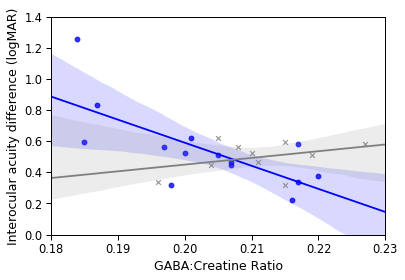

In [179]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0.18, 0.23)
ax.set_ylim(0, 1.4)
sns.regplot(data=amb_data, x='occGABA', y='iadLogMAR', color='blue', marker='o', ax=ax)
sns.regplot(data=amb_data, x='motorGABA', y='iadLogMAR', color='grey', marker='x', ax=ax)
ax.set_xlabel("GABA:Creatine Ratio")
ax.set_ylabel("Interocular acuity difference (logMAR)")